In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/share/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-04-14 11:05:56 __main__ INFO     torch.__version__='2.6.0+cu124', torch.version.cuda='12.4'
2025-04-14 11:05:56 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2025-04-14 11:05:56 __main__ INFO     transformers.__version__='4.51.2'


In [3]:
import torch

from nnsight import LanguageModel
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig


# model_key = "meta-llama/Llama-3.1-70B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.2-3B"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-2-27b-it"
# model_key = "google/gemma-3-12b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
model_key = "Qwen/Qwen2.5-14B"
# model_key = "Qwen/Qwen2.5-32B"

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)


2025-04-14 11:06:21 src.models WARNING  Qwen/Qwen2.5-14B not found in /share/u/models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-04-14 11:06:21 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-04-14 11:06:21 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/config.json HTTP/1.1" 200 0
2025-04-14 11:06:21 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


2025-04-14 11:06:24 accelerate.utils.modeling INFO     We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

2025-04-14 11:06:28 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /Qwen/Qwen2.5-14B/resolve/main/generation_config.json HTTP/1.1" 200 0


2025-04-14 11:06:29 src.models INFO     loaded model <Qwen/Qwen2.5-14B> | size: 28171.604 MB | dtype: torch.bfloat16 | device: cuda:0


In [4]:
# from nnsight import LanguageModel

# lm = LanguageModel(
#     model_key,
#     device_map="auto",
#     dispatch=True,
#     cache_dir = "/share/u/models",
#     torch_dtype=torch.bfloat16,
# )

In [5]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

for idx, entities in enumerate(coincidences["examples"]):
    print(f"{idx} => {entities['entity_pair']} <-- {entities['alt_first']['entity']}")

2025-04-14 11:06:36 __main__ INFO     len(coincidences['examples'])=13
0 => ['Germany', 'Japan'] <-- Korea
1 => ['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2 => ['Bhutan', 'Nepal'] <-- India
3 => ['Mount Athos', 'Vatican City'] <-- Italy
4 => ['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
5 => ['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
6 => ['Toph Beifong', 'Daredevil'] <-- Punisher
7 => ['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
8 => ['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
9 => ['Whale', 'Elephant'] <-- Horse
10 => ['jellyfish', 'lobster'] <-- salmon
11 => ['crocodile', 'shark'] <-- salmon
12 => ['spider', 'crab'] <-- lobster


In [6]:
from src.probing.utils import (
    ProbingPrompt,
    ProbingLatents,
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

Instructions = f"""Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = coincidences["examples"][0]["entity_pair"]
# entities = ("Whale", "Dolphin")
# entities = ("Nautilus", "Dolphin")
# entities = ("Abraham Lincoln", "John F. Kennedy")
# entities = ("Brad Pitt", "Angelina Jolie")
# entities = ("Emu", "Ostrich")
# entities = ("Elephant", "Whale")
# entities = ("Wolverine", "Penguin")
# entities = ("Giraffe", "Reindeer")
entities = coincidences["examples"][5]["entity_pair"]

print(entities)

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f"{answer=}")

['Leonardo da Vinci', 'Benjamin Franklin']
Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Leonardo da Vinci and Benjamin Frankli

In [7]:
from src.functional import PatchSpec
from src.functional import generate_with_patch, predict_next_token
from src.utils.typing import TokenizerOutput

print(entities)

clean_pred = predict_next_token(
    mt = mt,
    inputs = TokenizerOutput(data = prompt.tokenized),
)
clean_pred

['Leonardo da Vinci', 'Benjamin Franklin']


[[PredictedToken(token=' polym', prob=0.44140625, logit=19.5, token_id=44933),
  PredictedToken(token=' invent', prob=0.07666015625, logit=17.75, token_id=17023),
  PredictedToken(token=' artists', prob=0.052734375, logit=17.375, token_id=13511),
  PredictedToken(token=' famous', prob=0.052734375, logit=17.375, token_id=11245),
  PredictedToken(token=' Renaissance', prob=0.046630859375, logit=17.25, token_id=54283)]]

In [8]:
# single_probing_prompt = "Who/what is {}? Answer: {} is a"

# pred, track_ans = predict_next_token(
#     mt = mt,
#     inputs = [single_probing_prompt.format(entities[0], entities[0])],
#     k=15,
#     token_of_interest=[clean_pred[0][0].token_id]
# )

# print(track_ans)
# pred

In [9]:
# pred, track_ans = predict_next_token(
#     mt = mt,
#     inputs = single_probing_prompt.format(entities[1], entities[1]),
#     k=15,
#     token_of_interest=[clean_pred[0][0].token_id]
# )

# print(track_ans)
# pred

In [10]:
from src.functional import PatchSpec, generate_with_patch, interpret_logits, get_hs
from src.trace import get_score
from src.utils.typing import TokenizerOutput
from typing import Literal

@torch.inference_mode()
def patched_run(
    mt: ModelandTokenizer,
    inputs: TokenizerOutput,
    patches: list[PatchSpec],
    ans_tokens: list[int],
    metric: Literal["logit", "prob"] = "logit",
    generate_full_ans: bool = False,
    **next_tok_kwargs
):
    if generate_full_ans:
        answer = generate_with_patch(
            mt = mt,
            inputs = inputs,
            n_gen_per_prompt=1,
            do_sample=False,
            patches = patches,
            patch_strategy="replace",
            remove_prefix=True,
            patch_at_all_generations=False, # don't need to

            # patch_at_all_generations=True,    # will give the same result
            # use_cache = False,
        )
        print(f"\"{answer[0]}\"")
    
    logits = get_hs(
        mt = mt,
        input = inputs,
        locations = [(mt.lm_head_name, -1)],
        patches = patches,
        return_dict=False
    ).squeeze()

    pred, track = interpret_logits(
        tokenizer=mt,
        logits=logits,
        interested_tokens=ans_tokens,
        **next_tok_kwargs
    )

    score = get_score(logits = logits, token_id=ans_tokens, metric = metric)

    return score, pred, track

In [11]:
import baukit
from src.functional import PatchSpec
from src.utils.typing import Model
from nnsight import LanguageModel
from src.models import unwrap_model

def patch_with_baukit(
    model: ModelandTokenizer | Model,
    inputs: TokenizerOutput,
    patches: list[PatchSpec],
    model_kwargs: dict = {},
):
    if isinstance(model, ModelandTokenizer):
        model = unwrap_model(model)
    if isinstance(model, LanguageModel):
        model = model._model
    
    layers_to_indices = {}
    patch_dict = {}
    for patch in patches:
        layer, idx = patch.location
        if layer not in layers_to_indices:
            layers_to_indices[layer] = []
        layers_to_indices[layer].append(idx)
        patch_dict[patch.location] = patch.patch
    
    unique_modules = list(layers_to_indices.keys())
 
    def perform_patch(repr, layer_name):
        # print(layer_name)
        if layer_name not in unique_modules:
            return repr
        
        current_state = repr if "mlp" in layer_name else repr[0]
        for index in layers_to_indices[layer_name]:
            current_state[:, index, :] = patch_dict[(layer_name, index)]
        
        return repr


    with baukit.TraceDict(
        module = model,
        layers = unique_modules,
        edit_output = perform_patch
    ):
        output = model(**inputs, **model_kwargs)

    return output          

In [12]:
import types
from tqdm.auto import tqdm
from typing import Literal
from src.utils.typing import TokenizerOutput
from src.functional import predict_next_token, get_module_nnsight, interpret_logits
from src.hooking.llama_attention import AttentionEdge, LlamaAttentionPatcher
import baukit
from src.utils.typing import PredictedToken

def get_edges_to_be_ablated(
    prompt: ProbingPrompt,
    focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all",
    Q_IDX: int = -1, # almost always the last token position
    whitelist_key_indices: list[int] = [0, -1]
):
    for idx, ti in enumerate(whitelist_key_indices):
        if ti < 0:
            whitelist_key_indices[idx] = prompt.tokenized["input_ids"][0].shape[-1] + ti
    
    if focus_strategy == "entities":
        whitelist_key_indices += list(range(*prompt.entity_ranges[0])) + list(range(*prompt.entity_ranges[1]))
    elif focus_strategy == "entities_last":
        whitelist_key_indices += [prompt.entity_ranges[0][1] - 1, prompt.entity_ranges[1][1] - 1]
    elif focus_strategy == "ablate_all":
        pass
    else:
        raise ValueError(f"{focus_strategy=}")
    
    whitelist_key_indices = list(set(whitelist_key_indices))
    if Q_IDX < 0:
        Q_IDX = prompt.tokenized["input_ids"][0].shape[-1] + Q_IDX
    
    block_edges: list[AttentionEdge] = []
    for k_idx in range(0, prompt.tokenized["input_ids"][0].shape[-1]):
        if k_idx in whitelist_key_indices:
            continue
        block_edges.append(
            AttentionEdge(
                q_idx=Q_IDX,
                k_idx=k_idx,
            )
        )
    
    return block_edges

## Ablating the heads to check their importance

In [123]:
import types
from tqdm.auto import tqdm
from typing import Literal
from src.utils.typing import TokenizerOutput
from src.functional import predict_next_token, get_module_nnsight, interpret_logits
from src.hooking.llama_attention import AttentionEdge, LlamaAttentionPatcher
import baukit
from src.utils.typing import PredictedToken

    

@torch.inference_mode()
def attn_blocking_sweep_cumulative(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    direction: Literal["asc", "desc"] = "asc",
    step: int = 1,
    verbose: bool = False
):
    inputs = TokenizerOutput(data = prompt.tokenized)
    mt.reset_forward()
    
    ablate_all_heads_per_layer = {
        h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
    }

    effects = {}

    if direction == "asc":
        progress = tqdm(range(0, mt.n_layer, step))
    elif direction == "desc":
        progress = tqdm(range(mt.n_layer - 1, -1, -step))

    progress.set_description(f"{direction=}")

    for layer_idx in progress:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        # attn_block = get_module_nnsight(mt, attn_block_name)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                cut_attn_edges=ablate_all_heads_per_layer
            ),
            attn_block
        )

        ablated_pred, track_ans = predict_next_token(
            mt=mt, 
            inputs=inputs,
            token_of_interest=[clean_answer.token_id]
        )
        # output = mt._model(**inputs)
        # logits = output.logits[:, -1, :].squeeze()
        # ablated_pred, track_ans = interpret_logits(tokenizer=mt, logits=logits, interested_tokens=[answer.token_id])

        if verbose:
            logger.debug(f"{layer_idx}: {track_ans=}")

        effects[layer_idx] = {
            "track_ans": track_ans,
            "ablated_pred": ablated_pred,
        }
    

    mt.reset_forward()
    return effects

block_edges = get_edges_to_be_ablated(
    prompt=prompt,
    focus_strategy="entities",
    Q_IDX=-1,
    whitelist_key_indices=[0, -1]
)

blocking_effects = attn_blocking_sweep_cumulative(
    mt=mt, prompt=prompt,
    block_edges=block_edges,
    clean_answer=clean_pred[0][0],
    direction="desc",
)

direction='desc': 100%|██████████| 48/48 [01:23<00:00,  1.73s/it]


In [12]:
# focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all"

# block_edges = get_edges_to_be_ablated(
#     prompt=prompt,
#     focus_strategy=focus_strategy,
#     Q_IDX=-1,
#     whitelist_key_indices=[0, -1]
# )

# effects_asc = attn_blocking_sweep_cumulative(
#     mt=mt, prompt=prompt,
#     clean_answer=clean_pred[0][0],
#     block_edges=block_edges,
#     direction="asc",
# )
# effects_desc = attn_blocking_sweep_cumulative(
#     mt=mt, prompt=prompt,
#     clean_answer=clean_pred[0][0],
#     block_edges=block_edges,
#     direction="desc",
# )    

In [13]:
# clean_pred[0][0]

In [14]:
# import matplotlib.pyplot as plt

# metric = "prob"

# denom = getattr(clean_pred[0][0], metric)

# layers = list(range(mt.n_layer))
# values_asc = []
# for layer_idx in layers:
#     track_ans = list(effects_asc[layer_idx]["track_ans"][0].values())[0][1]
#     values_asc.append(getattr(track_ans, metric) / denom)

# values_desc = []
# for layer_idx in layers:
#     track_ans = list(effects_desc[layer_idx]["track_ans"][0].values())[0][1]
#     values_desc.append(getattr(track_ans, metric) / denom)


# plt.figure(figsize=(15, 5))
# plt.title(f"ATTN Ablation Effects ({metric}) | {focus_strategy}")

# plt.plot(values_asc, marker="o", label="asc")
# plt.plot(values_desc, marker="o", label="desc")

# plt.xticks(layers)
# plt.xlabel("Layer Index")
# plt.ylabel("ans_abl/ans")
# plt.legend()

# plt.show()

In [15]:
@torch.inference_mode()
def ablate_attn_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    layer_window: list[int],
    k = 5,
    debug_full_answer = False
):
    
    inputs = TokenizerOutput(data = prompt.tokenized)
    mt.reset_forward()

    ablate_all_heads_per_layer = {
        h_idx: block_edges for h_idx in range(mt.config.num_attention_heads)
    }

    for layer_idx in layer_window:
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                cut_attn_edges=ablate_all_heads_per_layer
            ),
            attn_block
        )

    if debug_full_answer:
        answer = get_lm_generated_answer(
            mt=mt, prompt=prompt, 
            is_a_reasoning_model="deepseek" in model_key.lower(),
            use_kv_cache=False
        )
        print(f"{answer=}")

    ablated_pred, track_ans = predict_next_token(
        mt=mt, 
        inputs=inputs,
        token_of_interest=[clean_answer.token_id],
        k=k
    )

    mt.reset_forward()

    return ablated_pred, track_ans

In [14]:
focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "ablate_all"

# layer_window = list(range(0, 5))
# layer_window = list(range(0, mt.n_layer))
# layer_window = list(range(10, 20))
layer_window = list(range(20, 45)) #! critical layers! "ablate_all" works. but "entities" does not work

block_edges = get_edges_to_be_ablated(
    prompt=prompt,
    focus_strategy=focus_strategy,
    Q_IDX=-1,
    whitelist_key_indices=[0, -1]
)

track_ans = ablate_attn_window(
    mt=mt, prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    layer_window=layer_window,
    debug_full_answer=True,
)

track_ans

answer='mammals.'


([[PredictedToken(token=' mammals', prob=0.0322265625, logit=14.0625, token_id=55569),
   PredictedToken(token=' very', prob=0.0302734375, logit=14.0, token_id=1602),
   PredictedToken(token=' in', prob=0.020751953125, logit=13.625, token_id=304),
   PredictedToken(token=' created', prob=0.018310546875, logit=13.5, token_id=3465),
   PredictedToken(token=' animals', prob=0.0172119140625, logit=13.4375, token_id=9898)]],
 [{71527: (144,
    PredictedToken(token=' apex', prob=0.0010986328125, logit=10.6875, token_id=71527))}])

In [15]:
from src.trace import get_window

def attn_blocking_sweep_window(
    mt: ModelandTokenizer,
    prompt: ProbingPrompt,
    clean_answer: PredictedToken,
    block_edges: list[AttentionEdge],
    window_size: int,
):
    effects = {}

    for layer_idx in tqdm(range(mt.n_layer), desc=f"{window_size=}"):
        layer_window = get_window("{}", layer_idx, window_size, mt.n_layer)
        layer_window = [int(l) for l in layer_window]
        ablated_pred, track_ans = ablate_attn_window(
            mt=mt,
            prompt=prompt,
            clean_answer=clean_answer,
            block_edges=block_edges,
            layer_window=layer_window,
        )
        effects[layer_idx] = dict(
            track_ans=track_ans,
            ablated_pred=ablated_pred,
        )
    return effects  

window_ablation_effects = attn_blocking_sweep_window(
    mt=mt, prompt=prompt,
    clean_answer=clean_pred[0][0],
    block_edges=block_edges,
    window_size=11,
)

window_size=11: 100%|██████████| 48/48 [00:44<00:00,  1.07it/s]


In [17]:
# window_ablation_effects

In [18]:
# from matplotlib import pyplot as plt

# metric = "prob"
# denom = getattr(clean_pred[0][0], metric)

# values = []
# layers = list(range(mt.n_layer))
# for layer_idx in layers:
#     track_ans = list(window_ablation_effects[layer_idx]["track_ans"][0].values())[0][1]
#     values.append(getattr(track_ans, metric) / denom)


# plt.figure(figsize=(15, 5))
# plt.plot(values, marker="o")
# plt.xticks(layers)

# plt.title(f"Ablate ATTN sweep (window size={5})")
# plt.xlabel("Layer Index")
# plt.ylabel("ans_abl/ans")
# plt.ylim(bottom=0)  
# plt.legend()

In [19]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

2025-02-19 10:47:42 __main__ INFO     len(coincidences['examples'])=20


In [28]:
focus_strategy: Literal["entities", "entities_last", "ablate_all"] = "entities"

effects = []

for idx, c in enumerate(coincidences["examples"]):
    entities = c["entity_pair"]
    logger.info(f"({idx+1}/{len(coincidences['examples'])})  {entities=}")

    prompt = prepare_probing_input(
        mt=mt,
        entities=entities,
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both"
    )

    clean_answer = predict_next_token(mt=mt, inputs = TokenizerOutput(data = prompt.tokenized), k=1)[0][0]
    logger.info(f"{clean_answer=}")

    block_edges = get_edges_to_be_ablated(
        prompt=prompt,
        focus_strategy=focus_strategy,
        Q_IDX=-2,
        whitelist_key_indices=[0]
        # whitelist_key_indices=[0, -1]
    )

    cumulative_effects_asc = attn_blocking_sweep_cumulative(
        mt=mt, prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        direction="asc",
    )

    cumulative_effects_desc = attn_blocking_sweep_cumulative(
        mt=mt, prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        direction="desc",
    )

    attn_ablation_effects = attn_blocking_sweep_window(
        mt=mt, prompt=prompt,
        clean_answer=clean_answer,
        block_edges=block_edges,
        window_size=5,
    )


    effects.append(dict(
        entities=entities,
        clean_answer=clean_answer,
        attn_ablation_effects=attn_ablation_effects,
        cumulative_effects=dict(
            asc=cumulative_effects_asc,
            desc=cumulative_effects_desc
        )
    ))

    print("-" * 80)

2025-02-19 11:17:53 __main__ INFO     (1/20)  entities=['Germany', 'Japan']


2025-02-19 11:17:53 __main__ INFO     clean_answer=PredictedToken(token=' Axis', prob=0.2440185546875, logit=16.1875, token_id=35574)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]

--------------------------------------------------------------------------------
2025-02-19 11:19:09 __main__ INFO     (2/20)  entities=['Hugh Jackman', 'Ryan Reynolds']


2025-02-19 11:19:09 __main__ INFO     clean_answer=PredictedToken(token=' X', prob=0.15087890625, logit=15.5859375, token_id=1630)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]

--------------------------------------------------------------------------------
2025-02-19 11:20:24 __main__ INFO     (3/20)  entities=['Bhutan', 'Tuvalu']


2025-02-19 11:20:25 __main__ INFO     clean_answer=PredictedToken(token=' monarch', prob=0.1822509765625, logit=16.046875, token_id=63854)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.33it/s]

--------------------------------------------------------------------------------
2025-02-19 11:21:41 __main__ INFO     (4/20)  entities=['Vatican City', 'Mount Athos']


2025-02-19 11:21:41 __main__ INFO     clean_answer=PredictedToken(token=' independent', prob=0.121826171875, logit=15.4296875, token_id=9678)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]

--------------------------------------------------------------------------------
2025-02-19 11:22:55 __main__ INFO     (5/20)  entities=['Rosetta Stone', 'Dead Sea Scrolls']


2025-02-19 11:22:56 __main__ INFO     clean_answer=PredictedToken(token=' ancient', prob=0.3876953125, logit=17.703125, token_id=14154)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]

--------------------------------------------------------------------------------
2025-02-19 11:24:10 __main__ INFO     (6/20)  entities=['Leonardo da Vinci', 'Benjamin Franklin']


2025-02-19 11:24:10 __main__ INFO     clean_answer=PredictedToken(token=' polym', prob=0.29150390625, logit=17.171875, token_id=46033)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]

--------------------------------------------------------------------------------
2025-02-19 11:25:26 __main__ INFO     (7/20)  entities=['Daredevil', 'Toph Beifong']


2025-02-19 11:25:26 __main__ INFO     clean_answer=PredictedToken(token=' blind', prob=0.7431640625, logit=18.484375, token_id=18507)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s]

--------------------------------------------------------------------------------
2025-02-19 11:26:42 __main__ INFO     (8/20)  entities=['Memento', 'Inception']


2025-02-19 11:26:42 __main__ INFO     clean_answer=PredictedToken(token=' directed', prob=0.724609375, logit=18.453125, token_id=15910)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]

--------------------------------------------------------------------------------
2025-02-19 11:27:57 __main__ INFO     (9/20)  entities=['Julius Caesar', 'Nepoleon Bonaparte']


2025-02-19 11:27:58 __main__ INFO     clean_answer=PredictedToken(token=' military', prob=0.241455078125, logit=17.53125, token_id=6411)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s]

--------------------------------------------------------------------------------
2025-02-19 11:29:14 __main__ INFO     (10/20)  entities=['The Godfather', 'Goodfellas']


2025-02-19 11:29:14 __main__ INFO     clean_answer=PredictedToken(token=' mob', prob=0.1612548828125, logit=16.96875, token_id=12881)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]

--------------------------------------------------------------------------------
2025-02-19 11:30:31 __main__ INFO     (11/20)  entities=['The Green Mile', 'The Shawshank Redemption']


2025-02-19 11:30:31 __main__ INFO     clean_answer=PredictedToken(token=' directed', prob=0.1981201171875, logit=15.9140625, token_id=15910)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]

--------------------------------------------------------------------------------
2025-02-19 11:31:48 __main__ INFO     (12/20)  entities=['Christopher Columbus', 'Vasco da Gama']


2025-02-19 11:31:48 __main__ INFO     clean_answer=PredictedToken(token=' explor', prob=0.45458984375, logit=18.71875, token_id=48539)


window_size=5: 100%|██████████| 32/32 [00:16<00:00,  1.94it/s]

--------------------------------------------------------------------------------
2025-02-19 11:33:08 __main__ INFO     (13/20)  entities=['Elephant', 'Whale']


2025-02-19 11:33:09 __main__ INFO     clean_answer=PredictedToken(token=' mammals', prob=0.310302734375, logit=16.71875, token_id=56669)


window_size=5: 100%|██████████| 32/32 [00:16<00:00,  1.93it/s]

--------------------------------------------------------------------------------
2025-02-19 11:34:33 __main__ INFO     (14/20)  entities=['Emu', 'Ostrich']


2025-02-19 11:34:34 __main__ INFO     clean_answer=PredictedToken(token=' flight', prob=0.406982421875, logit=17.03125, token_id=11213)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]

--------------------------------------------------------------------------------
2025-02-19 11:35:52 __main__ INFO     (15/20)  entities=['Brazil', 'Turkey']


2025-02-19 11:35:52 __main__ INFO     clean_answer=PredictedToken(token=' members', prob=0.22412109375, logit=15.78125, token_id=3697)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]

--------------------------------------------------------------------------------
2025-02-19 11:37:08 __main__ INFO     (16/20)  entities=['jellyfish', 'lobster']


2025-02-19 11:37:08 __main__ INFO     clean_answer=PredictedToken(token=' in', prob=0.201904296875, logit=15.6484375, token_id=304)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]

--------------------------------------------------------------------------------
2025-02-19 11:38:23 __main__ INFO     (17/20)  entities=['corn', 'wheat']


2025-02-19 11:38:23 __main__ INFO     clean_answer=PredictedToken(token=' staple', prob=0.1856689453125, logit=17.078125, token_id=50056)


window_size=5: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]

--------------------------------------------------------------------------------
2025-02-19 11:39:39 __main__ INFO     (18/20)  entities=['crocodile', 'shark']


2025-02-19 11:39:39 __main__ INFO     clean_answer=PredictedToken(token=' apex', prob=0.1292724609375, logit=15.6875, token_id=72627)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.22it/s]

--------------------------------------------------------------------------------
2025-02-19 11:40:55 __main__ INFO     (19/20)  entities=['crab', 'spider']


2025-02-19 11:40:56 __main__ INFO     clean_answer=PredictedToken(token=' ar', prob=0.4072265625, logit=16.71875, token_id=802)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.25it/s]

--------------------------------------------------------------------------------
2025-02-19 11:42:12 __main__ INFO     (20/20)  entities=['copper', 'gold']


2025-02-19 11:42:12 __main__ INFO     clean_answer=PredictedToken(token=' used', prob=0.4423828125, logit=18.171875, token_id=1511)


window_size=5: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]

--------------------------------------------------------------------------------


In [31]:
def get_metric_value(track_ans, metric):
    rank, pred = list(track_ans[0].values())[0]
    if metric in ["prob", "logit"]:
        return getattr(pred, metric)
    elif metric == "reciprocal_rank":
        return 1 / rank

from src.utils.metrics import AggregateMetric
from typing import Optional
def process_effects_per_layer(
    effects: list[dict],
    metric: Literal["logit", "prob", "reciprocal_rank"] = "prob",
    v_clean_ans: Optional[list[float]] = None
):
    if v_clean_ans is not None:
        assert metric in ["logit", "prob"]
        assert len(v_clean_ans) == len(effects)

    layer_wise_results: dict[int, AggregateMetric] = {}
    layer_indices = list(range(mt.n_layer))
    for layer_idx in layer_indices:
        values = []
        for idx, e in enumerate(effects):
            track_ans = e[int(layer_idx)]["track_ans"]
            v = get_metric_value(track_ans, metric)
            if v_clean_ans is not None:
                v /= v_clean_ans[idx]
            values.append(v)
        layer_wise_results[layer_idx] = AggregateMetric.aggregate(values)
    return layer_wise_results


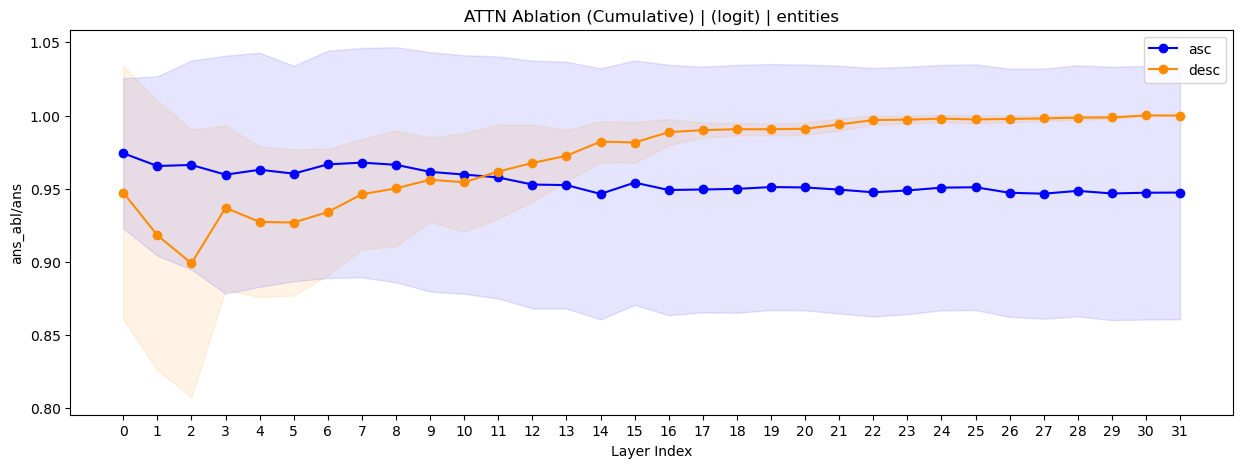

In [36]:
from matplotlib import pyplot as plt

metric: Literal["logit", "prob", "reciprocal_rank"] = "logit"

effects_asc = process_effects_per_layer(
    effects=[e["cumulative_effects"]["asc"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects] if metric in ["logit", "prob"] else None
)


effects_desc = process_effects_per_layer(
    effects=[e["cumulative_effects"]["desc"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects] if metric in ["logit", "prob"] else None
)

def plot_metric(results: dict[int, AggregateMetric], keys: list, label: str, color:str, canvas=plt):
    values = [results[k].mean for k in keys]
    stds = [results[k].stdev for k in keys]
    canvas.plot(values, marker="o", label=label, color=color)
    canvas.fill_between(keys, [v - s for v, s in zip(values, stds)], [v + s for v, s in zip(values, stds)], alpha=0.1, color=color)


plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation (Cumulative) | ({metric}) | {focus_strategy}")

layers = list(range(mt.n_layer))
plot_metric(effects_asc, layers, "asc", color="blue")
plot_metric(effects_desc, layers, "desc", color="darkorange")

plt.xticks(layers)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.legend()

plt.show()

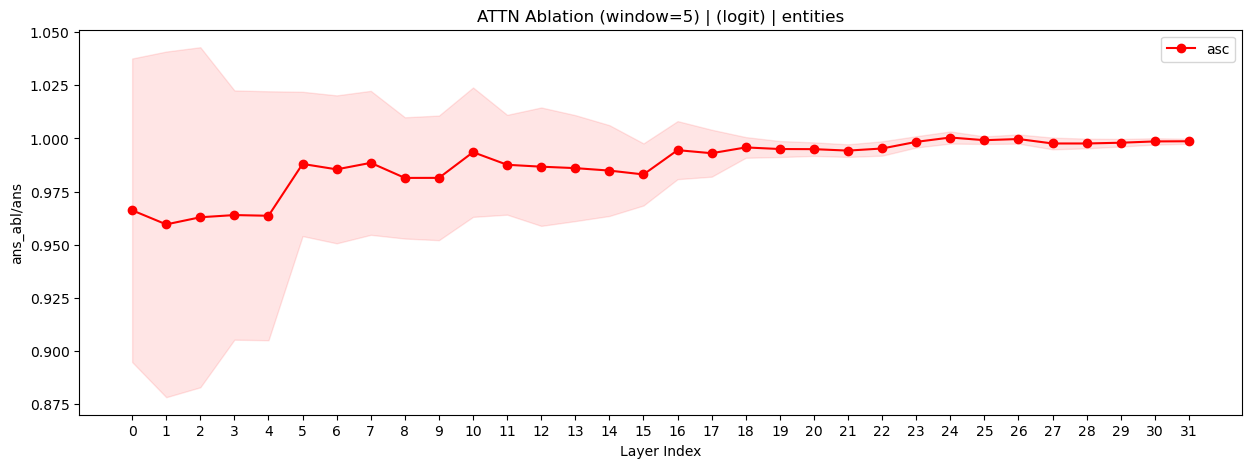

In [37]:
effects_window = process_effects_per_layer(
    effects=[e["attn_ablation_effects"] for e in effects],
    metric=metric,
    v_clean_ans=[getattr(e["clean_answer"], metric) for e in effects] if metric in ["logit", "prob"] else None
)

plt.figure(figsize=(15, 5))
plt.title(f"ATTN Ablation (window=5) | ({metric}) | {focus_strategy}")

plot_metric(effects_window, list(effects_asc.keys()), "asc", color="red")

plt.xticks(layers)
plt.xlabel("Layer Index")
plt.ylabel("ans_abl/ans")
plt.legend()

plt.show()

## Patching from a different run to check contribution

In [107]:
sample_idx = 0
sample = coincidences["examples"][sample_idx]
sample

{'entity_pair': ['Germany', 'Japan'],
 'connection': 'Axis powers in World War II.',
 'alt_first': {'entity': 'Korea',
  'connection': 'divided into North and South.'}}

In [108]:
patch_prompt = prepare_probing_input(
    mt=mt,
    entities=sample["entity_pair"],
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)


answer = get_lm_generated_answer(
    mt=mt, prompt=prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["entity_pair"]} >> {answer=}')

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(sample["alt_first"]["entity"], sample["entity_pair"][1]), 
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
)

clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["alt_first"]["entity"], sample["entity_pair"][1]} >> {clean_answer=}')

['Germany', 'Japan'] >> answer='polymaths.'
('Korea', 'Japan') >> clean_answer='part of the same empire.'


In [109]:
from src.functional import get_keywords

keywords = get_keywords(text = answer, tokenizer=mt)
keywords

[44933]

In [12]:
from src.functional import get_hs
from src.trace import calculate_indirect_effects

patch_attn_outputs = get_hs(
    mt = mt,
    input = patch_prompt.prompt,
    locations = [(mt.attn_module_name_format.format(l), -1) for l in range(mt.n_layer)],
    return_dict=True
)

In [13]:
# from src.utils.typing import TokenizerOutput

# ie = calculate_indirect_effects(
#     mt = mt,
#     locations = [(30, -1)],
#     corrupted_input = TokenizerOutput(data = clean_prompt.tokenized),
#     patch_states = patch_attn_outputs,
#     patch_ans_t=keywords,
#     layer_name_format=mt.attn_module_name_format,
#     window_size=11,
#     metric = "logit" 
# )

# ie

In [ ]:
patch_attn_outputs = get_hs(
    mt = mt,
    input = patch_prompt.prompt,
    locations = [(mt.attn_module_name_format.format(l), -1) for l in range(mt.n_layer)],
    return_dict=True
)

# layer_idx = 30
# layer_window = get_window(mt.attn_module_name_format, layer_idx, 5, mt.n_layer)
layer_window = range(28, 35)
# layer_window = range(10, 20)
# layer_window = range(40, mt.n_layer-2)

gold_score, gold_pred, gold_track = patched_run(
    mt = mt,
    inputs = TokenizerOutput(data = patch_prompt.tokenized),
    patches = [],
    ans_tokens = keywords,
    # generate_full_ans = True,
    metric = "logit",
)
print(f"{gold_score=}")

corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt = mt,
    inputs = TokenizerOutput(data = clean_prompt.tokenized),
    patches = [],
    ans_tokens = keywords,
    # generate_full_ans = True,
    metric = "logit",
)
print(f"{corrupt_score=}")



layer_window = [mt.attn_module_name_format.format(l) for l in layer_window]
tokenized_input = TokenizerOutput(data = clean_prompt.tokenized)
last_tok_idx = tokenized_input.input_ids.shape[1] - 1

patches = [
    PatchSpec(
        location = (layer, last_tok_idx),
        patch = 2 * patch_attn_outputs[(layer, -1)]
    ) for layer in layer_window
]
# patches = []

patched_score, pred, track = patched_run(
    mt = mt,
    inputs = tokenized_input,
    patches = patches,
    ans_tokens = keywords,
    generate_full_ans = True,
    metric = "logit",
)

print(f"{patched_score=}")
print(f"{pred=}")
print(f"{track=}")

gold_score=19.671875
corrupt_score=11.703125
" polymaths.
#
Q: The White House and The Pentagon
A: They are both government buildings"
patched_score=18.234375
pred=[PredictedToken(token=' polym', prob=0.219970703125, logit=18.234375, token_id=44933), PredictedToken(token=' famous', prob=0.13134765625, logit=17.71875, token_id=11245), PredictedToken(token=' invent', prob=0.0875244140625, logit=17.3125, token_id=17023), PredictedToken(token=' American', prob=0.07843017578125, logit=17.203125, token_id=3693), PredictedToken(token=' Renaissance', prob=0.03271484375, logit=16.328125, token_id=54283)]
track={44933: (1, PredictedToken(token=' polym', prob=0.219970703125, logit=18.234375, token_id=44933))}


In [15]:
from src.functional import get_keywords
from src.trace import get_window
from typing import Optional

@torch.inference_mode()
def do_patching_sweep(
    mt: ModelandTokenizer,
    samples: list[dict],
    layers: Optional[list[int]] = None,
    token_idx = -1, #TODO: incorporate different key positions like: subj_last, token_last, all_subj, ...
    metric: Literal["logit", "prob"] = "logit",
    coeff: float = 1.0,
    kind: Literal["mlp", "attn", "residual"] = "attn",
    window: int | Literal["from", "upto"] = 5,
) -> dict:
    layers = list(range(mt.n_layer)) if layers is None else layers
    module_name_format = {
        "residual": mt.layer_name_format,
        "mlp": mt.mlp_module_name_format,
        "attn": mt.attn_module_name_format,
    }[kind]

    results = []
    for idx, sample in tqdm(enumerate(samples)):
        logger.info(f"({idx+1}/{len(samples)})  {sample['entity_pair']=} <-- {sample['alt_first']['entity']}")
        patch_prompt = prepare_probing_input(
            mt=mt,
            entities=sample["entity_pair"],
            prefix=prefix,
            answer_marker=answer_marker,
            question_marker=question_marker,
            block_separator=block_separator,
            is_a_reasoning_model="deepseek" in model_key.lower(),
            answer_prefix=" They are/were both"
        )
        answer = get_lm_generated_answer(
            mt=mt, prompt=patch_prompt, 
            is_a_reasoning_model="deepseek" in model_key.lower()
        )
        logger.info(f'{sample["entity_pair"]} >> {answer=}')

        clean_prompt = prepare_probing_input(
            mt=mt,
            entities=(sample["alt_first"]["entity"], sample["entity_pair"][1]), 
            prefix=prefix,
            answer_marker=answer_marker,
            question_marker=question_marker,
            block_separator=block_separator,
            is_a_reasoning_model="deepseek" in model_key.lower(),
            answer_prefix=" They are/were both"
        )

        clean_answer = get_lm_generated_answer(
            mt=mt, prompt=clean_prompt, 
            is_a_reasoning_model="deepseek" in model_key.lower()
        )
        logger.info(f'{sample["alt_first"]["entity"], sample["entity_pair"][1]} >> {clean_answer=}')

        answer_tokens = get_keywords(text = answer, tokenizer=mt)
        logger.info(f'{[f"{t}({mt.tokenizer.decode(t)})" for t in answer_tokens]}')


        gold_score, gold_pred, gold_track = patched_run(
            mt = mt,
            inputs = TokenizerOutput(data = patch_prompt.tokenized),
            patches = [],
            ans_tokens = answer_tokens,
            metric=metric
        )
        logger.info(f"{gold_score=}")

        corrupt_score, corrupt_pred, corrupt_track = patched_run(
            mt = mt,
            inputs = TokenizerOutput(data = clean_prompt.tokenized),
            patches = [],
            ans_tokens = answer_tokens,
            metric=metric
        )
        logger.info(f"{corrupt_score=}")
        

        patch_layers = {}
        unique_layers = []
        for layer_idx in layers:
            if window == "from":
                layer_window = range(layer_idx, mt.n_layer)
            elif window == "upto":
                layer_window = range(0, layer_idx + 1)
            else:
                assert isinstance(window, int)
                layer_window = [int(l) for l in get_window("{}", layer_idx, window, mt.n_layer)]
            
            patch_layers[layer_idx] = [module_name_format.format(l) for l in layer_window]
            unique_layers += patch_layers[layer_idx]

        unique_layers = set(unique_layers)

        patch_outputs = get_hs(
            mt = mt,
            input = patch_prompt.prompt,
            locations = [(l, token_idx) for l in unique_layers],
            return_dict = True
        )

        patching_results = {}
        clean_input = TokenizerOutput(data = clean_prompt.tokenized)

        #! currently assumes `token_idx to cache state from LM(patch_input) == token_idx to patch to LM(clean_input)` (change?)
        patch_token_idx = token_idx
        if patch_token_idx < 0:
            patch_token_idx = clean_input.input_ids.shape[1] + token_idx

        for layer_idx, layer_window in patch_layers.items():

            patches = [
                PatchSpec(
                    location = (layer, patch_token_idx),
                    patch = coeff * patch_outputs[(layer, token_idx)]
                ) for layer in layer_window
            ]

            patched_score, pred, track = patched_run(
                mt = mt,
                inputs = clean_input,
                patches = patches,
                ans_tokens = answer_tokens,
                generate_full_ans = False,
                metric = metric
            )

            logger.debug(f"         {layer_idx=}, {patched_score=}")
            # print(layer_window)

            patching_results[layer_idx] = dict(
                score=patched_score,
                pred=pred,
                track=track,
            )
        
        logger.debug("-"*30)
        
        results.append(dict(
            sample = sample,
            answer = answer,
            answer_tokens = answer_tokens,
            gold_score = gold_score,
            corrupt_score = corrupt_score,
            patching_results = patching_results,
        ))

    return results
            

kwargs = dict(
    mt = mt,
    # samples = [coincidences["examples"][sample_idx]],
    samples = coincidences["examples"],
    token_idx = -1,
    metric = "logit",
    coeff = 1.0,
    kind = "attn",
)

res_from = do_patching_sweep(
    **kwargs,
    window = "from",
)

res_upto = do_patching_sweep(
    **kwargs,
    window = "upto",
)

res_win = do_patching_sweep(
    **kwargs,
    window = 5,
)

0it [00:00, ?it/s]

2025-04-07 16:56:20 __main__ INFO     (1/13)  sample['entity_pair']=['Germany', 'Japan'] <-- Korea


2025-04-07 16:56:25 __main__ INFO     ['Germany', 'Japan'] >> answer='Axis powers in World War II.'
2025-04-07 16:56:31 __main__ INFO     ('Korea', 'Japan') >> clean_answer='part of the Japanese Empire.'
2025-04-07 16:56:31 __main__ INFO     ['34474( Axis)', '13430( powers)', '4337( World)', '5004( War)', '7946( II)']
2025-04-07 16:56:31 __main__ INFO     gold_score=12.6796875
2025-04-07 16:56:31 __main__ INFO     corrupt_score=9.96875
2025-04-07 16:56:31 __main__ DEBUG             layer_idx=0, patched_score=12.8125
2025-04-07 16:56:31 __main__ DEBUG             layer_idx=1, patched_score=12.765625
2025-04-07 16:56:32 __main__ DEBUG             layer_idx=2, patched_score=12.703125
2025-04-07 16:56:32 __main__ DEBUG             layer_idx=3, patched_score=12.609375
2025-04-07 16:56:32 __main__ DEBUG             layer_idx=4, patched_score=12.6953125
2025-04-07 16:56:32 __main__ DEBUG             layer_idx=5, patched_score=12.6328125
2025-04-07 16:56:32 __main__ DEBUG             layer_idx

1it [00:19, 19.83s/it]

2025-04-07 16:56:40 __main__ INFO     (2/13)  sample['entity_pair']=['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2025-04-07 16:56:45 __main__ INFO     ['Hugh Jackman', 'Ryan Reynolds'] >> answer='actors and friends.'
2025-04-07 16:56:51 __main__ INFO     ('Celine Dion', 'Ryan Reynolds') >> clean_answer='married to the same person.'
2025-04-07 16:56:51 __main__ INFO     ['19571( actors)', '4780( friends)']
2025-04-07 16:56:51 __main__ INFO     gold_score=17.328125
2025-04-07 16:56:51 __main__ INFO     corrupt_score=15.515625
2025-04-07 16:56:51 __main__ DEBUG             layer_idx=0, patched_score=17.28125
2025-04-07 16:56:52 __main__ DEBUG             layer_idx=1, patched_score=17.265625
2025-04-07 16:56:52 __main__ DEBUG             layer_idx=2, patched_score=17.25
2025-04-07 16:56:52 __main__ DEBUG             layer_idx=3, patched_score=17.265625
2025-04-07 16:56:52 __main__ DEBUG             layer_idx=4, patched_score=17.296875
2025-04-07 16:56:52 __main__ DEBUG             lay

2it [00:40, 20.17s/it]

2025-04-07 16:57:00 __main__ INFO     (3/13)  sample['entity_pair']=['Bhutan', 'Nepal'] <-- India
2025-04-07 16:57:06 __main__ INFO     ['Bhutan', 'Nepal'] >> answer='monarchies.'
2025-04-07 16:57:11 __main__ INFO     ('India', 'Nepal') >> clean_answer='ruled by the British Empire.'
2025-04-07 16:57:11 __main__ INFO     ['62754( monarch)']
2025-04-07 16:57:11 __main__ INFO     gold_score=18.71875
2025-04-07 16:57:11 __main__ INFO     corrupt_score=15.578125
2025-04-07 16:57:12 __main__ DEBUG             layer_idx=0, patched_score=18.6875
2025-04-07 16:57:12 __main__ DEBUG             layer_idx=1, patched_score=18.734375
2025-04-07 16:57:12 __main__ DEBUG             layer_idx=2, patched_score=18.71875
2025-04-07 16:57:12 __main__ DEBUG             layer_idx=3, patched_score=18.796875
2025-04-07 16:57:13 __main__ DEBUG             layer_idx=4, patched_score=18.625
2025-04-07 16:57:13 __main__ DEBUG             layer_idx=5, patched_score=18.75
2025-04-07 16:57:13 __main__ DEBUG          

3it [01:00, 20.28s/it]

2025-04-07 16:57:20 __main__ INFO     (4/13)  sample['entity_pair']=['Mount Athos', 'Vatican City'] <-- Italy
2025-04-07 16:57:26 __main__ INFO     ['Mount Athos', 'Vatican City'] >> answer='ruled by the Byzantine Empire.'
2025-04-07 16:57:31 __main__ INFO     ('Italy', 'Vatican City') >> clean_answer='ruled by the Pope.'
2025-04-07 16:57:31 __main__ INFO     ['21286( ruled)', '81660( Byz)', '20448( Empire)']
2025-04-07 16:57:32 __main__ INFO     gold_score=11.4453125
2025-04-07 16:57:32 __main__ INFO     corrupt_score=11.9375
2025-04-07 16:57:32 __main__ DEBUG             layer_idx=0, patched_score=11.5546875
2025-04-07 16:57:32 __main__ DEBUG             layer_idx=1, patched_score=11.4609375
2025-04-07 16:57:33 __main__ DEBUG             layer_idx=2, patched_score=11.5390625
2025-04-07 16:57:33 __main__ DEBUG             layer_idx=3, patched_score=11.5
2025-04-07 16:57:33 __main__ DEBUG             layer_idx=4, patched_score=11.515625
2025-04-07 16:57:33 __main__ DEBUG             la

4it [01:21, 20.34s/it]

2025-04-07 16:57:41 __main__ INFO     (5/13)  sample['entity_pair']=['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
2025-04-07 16:57:46 __main__ INFO     ['Dead Sea Scrolls', 'Rosetta Stone'] >> answer='important historical artifacts.'
2025-04-07 16:57:52 __main__ INFO     ('Pyramid of Giza', 'Rosetta Stone') >> clean_answer='located in Egypt.'
2025-04-07 16:57:52 __main__ INFO     ['2989( important)', '13656( historical)', '35036( artifacts)']
2025-04-07 16:57:52 __main__ INFO     gold_score=17.75
2025-04-07 16:57:52 __main__ INFO     corrupt_score=17.9375
2025-04-07 16:57:53 __main__ DEBUG             layer_idx=0, patched_score=17.75
2025-04-07 16:57:53 __main__ DEBUG             layer_idx=1, patched_score=17.6875
2025-04-07 16:57:53 __main__ DEBUG             layer_idx=2, patched_score=17.75
2025-04-07 16:57:53 __main__ DEBUG             layer_idx=3, patched_score=17.796875
2025-04-07 16:57:53 __main__ DEBUG             layer_idx=4, patched_score=17.671875
2025-04-07 16:57

5it [01:41, 20.42s/it]

2025-04-07 16:58:01 __main__ INFO     (6/13)  sample['entity_pair']=['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
2025-04-07 16:58:07 __main__ INFO     ['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
2025-04-07 16:58:13 __main__ INFO     ('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'
2025-04-07 16:58:13 __main__ INFO     ['44933( polym)']
2025-04-07 16:58:13 __main__ INFO     gold_score=19.671875
2025-04-07 16:58:13 __main__ INFO     corrupt_score=11.703125
2025-04-07 16:58:13 __main__ DEBUG             layer_idx=0, patched_score=19.59375
2025-04-07 16:58:13 __main__ DEBUG             layer_idx=1, patched_score=19.484375
2025-04-07 16:58:14 __main__ DEBUG             layer_idx=2, patched_score=19.5
2025-04-07 16:58:14 __main__ DEBUG             layer_idx=3, patched_score=19.515625
2025-04-07 16:58:14 __main__ DEBUG             layer_idx=4, patched_score=19.53125
2025-04-07 16:58:14 __main__ DEBUG             layer

6it [02:02, 20.48s/it]

2025-04-07 16:58:22 __main__ INFO     (7/13)  sample['entity_pair']=['Toph Beifong', 'Daredevil'] <-- Punisher
2025-04-07 16:58:28 __main__ INFO     ['Toph Beifong', 'Daredevil'] >> answer='blind and have superhuman abilities.'
2025-04-07 16:58:33 __main__ INFO     ('Punisher', 'Daredevil') >> clean_answer='Marvel comic book characters.'
2025-04-07 16:58:33 __main__ INFO     ['18020( blind)', '2256( super)', '17541( abilities)']
2025-04-07 16:58:33 __main__ INFO     gold_score=14.8828125
2025-04-07 16:58:33 __main__ INFO     corrupt_score=10.4140625
2025-04-07 16:58:34 __main__ DEBUG             layer_idx=0, patched_score=14.890625
2025-04-07 16:58:34 __main__ DEBUG             layer_idx=1, patched_score=14.8984375
2025-04-07 16:58:34 __main__ DEBUG             layer_idx=2, patched_score=14.859375
2025-04-07 16:58:34 __main__ DEBUG             layer_idx=3, patched_score=14.890625
2025-04-07 16:58:35 __main__ DEBUG             layer_idx=4, patched_score=14.90625
2025-04-07 16:58:35 __ma

7it [02:22, 20.47s/it]

2025-04-07 16:58:43 __main__ INFO     (8/13)  sample['entity_pair']=['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
2025-04-07 16:58:48 __main__ INFO     ['Julius Caesar', 'Nepoleon Bonaparte'] >> answer='military leaders.'
2025-04-07 16:58:54 __main__ INFO     ('Victor Hugo', 'Nepoleon Bonaparte') >> clean_answer='French.'
2025-04-07 16:58:54 __main__ INFO     ['6277( military)', '6036( leaders)']
2025-04-07 16:58:54 __main__ INFO     gold_score=18.578125
2025-04-07 16:58:54 __main__ INFO     corrupt_score=14.6953125
2025-04-07 16:58:54 __main__ DEBUG             layer_idx=0, patched_score=18.484375
2025-04-07 16:58:54 __main__ DEBUG             layer_idx=1, patched_score=18.515625
2025-04-07 16:58:55 __main__ DEBUG             layer_idx=2, patched_score=18.5
2025-04-07 16:58:55 __main__ DEBUG             layer_idx=3, patched_score=18.59375
2025-04-07 16:58:55 __main__ DEBUG             layer_idx=4, patched_score=18.578125
2025-04-07 16:58:55 __main__ DEBUG             layer_i

8it [02:43, 20.55s/it]

2025-04-07 16:59:03 __main__ INFO     (9/13)  sample['entity_pair']=['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
2025-04-07 16:59:09 __main__ INFO     ['Christopher Columbus', 'Vasco da Gama'] >> answer='explorers.'
2025-04-07 16:59:14 __main__ INFO     ('Christiano Ronaldo', 'Vasco da Gama') >> clean_answer='Portuguese.'
2025-04-07 16:59:14 __main__ INFO     ['47439( explor)']
2025-04-07 16:59:14 __main__ INFO     gold_score=20.671875
2025-04-07 16:59:14 __main__ INFO     corrupt_score=12.9453125
2025-04-07 16:59:15 __main__ DEBUG             layer_idx=0, patched_score=20.671875
2025-04-07 16:59:15 __main__ DEBUG             layer_idx=1, patched_score=20.625
2025-04-07 16:59:15 __main__ DEBUG             layer_idx=2, patched_score=20.65625
2025-04-07 16:59:15 __main__ DEBUG             layer_idx=3, patched_score=20.6875
2025-04-07 16:59:16 __main__ DEBUG             layer_idx=4, patched_score=20.75
2025-04-07 16:59:16 __main__ DEBUG             layer_idx=5, patched

9it [03:03, 20.50s/it]

2025-04-07 16:59:24 __main__ INFO     (10/13)  sample['entity_pair']=['Whale', 'Elephant'] <-- Horse
2025-04-07 16:59:29 __main__ INFO     ['Whale', 'Elephant'] >> answer='mammals.'
2025-04-07 16:59:35 __main__ INFO     ('Horse', 'Elephant') >> clean_answer='used as war animals.'
2025-04-07 16:59:35 __main__ INFO     ['55569( mammals)']
2025-04-07 16:59:35 __main__ INFO     gold_score=18.640625
2025-04-07 16:59:35 __main__ INFO     corrupt_score=15.5703125
2025-04-07 16:59:35 __main__ DEBUG             layer_idx=0, patched_score=18.59375
2025-04-07 16:59:36 __main__ DEBUG             layer_idx=1, patched_score=18.546875
2025-04-07 16:59:36 __main__ DEBUG             layer_idx=2, patched_score=18.53125
2025-04-07 16:59:36 __main__ DEBUG             layer_idx=3, patched_score=18.625
2025-04-07 16:59:36 __main__ DEBUG             layer_idx=4, patched_score=18.640625
2025-04-07 16:59:36 __main__ DEBUG             layer_idx=5, patched_score=18.5625
2025-04-07 16:59:37 __main__ DEBUG        

10it [03:24, 20.48s/it]

2025-04-07 16:59:44 __main__ INFO     (11/13)  sample['entity_pair']=['jellyfish', 'lobster'] <-- salmon
2025-04-07 16:59:50 __main__ INFO     ['jellyfish', 'lobster'] >> answer='eaten by the same person.'
2025-04-07 16:59:55 __main__ INFO     ('salmon', 'lobster') >> clean_answer='served at the White House.'
2025-04-07 16:59:55 __main__ INFO     ['34561( eaten)', '1697( person)']
2025-04-07 16:59:55 __main__ INFO     gold_score=11.625
2025-04-07 16:59:55 __main__ INFO     corrupt_score=11.5234375
2025-04-07 16:59:56 __main__ DEBUG             layer_idx=0, patched_score=11.59375
2025-04-07 16:59:56 __main__ DEBUG             layer_idx=1, patched_score=11.6015625
2025-04-07 16:59:56 __main__ DEBUG             layer_idx=2, patched_score=11.6015625
2025-04-07 16:59:56 __main__ DEBUG             layer_idx=3, patched_score=11.578125
2025-04-07 16:59:57 __main__ DEBUG             layer_idx=4, patched_score=11.5859375
2025-04-07 16:59:57 __main__ DEBUG             layer_idx=5, patched_score=1

11it [03:44, 20.43s/it]

2025-04-07 17:00:04 __main__ INFO     (12/13)  sample['entity_pair']=['crocodile', 'shark'] <-- salmon
2025-04-07 17:00:10 __main__ INFO     ['crocodile', 'shark'] >> answer='apex predators.'
2025-04-07 17:00:15 __main__ INFO     ('salmon', 'shark') >> clean_answer='fish.'
2025-04-07 17:00:15 __main__ INFO     ['71527( apex)', '55117( predators)']
2025-04-07 17:00:15 __main__ INFO     gold_score=17.375
2025-04-07 17:00:16 __main__ INFO     corrupt_score=16.3125
2025-04-07 17:00:16 __main__ DEBUG             layer_idx=0, patched_score=17.296875
2025-04-07 17:00:16 __main__ DEBUG             layer_idx=1, patched_score=17.34375
2025-04-07 17:00:16 __main__ DEBUG             layer_idx=2, patched_score=17.390625
2025-04-07 17:00:17 __main__ DEBUG             layer_idx=3, patched_score=17.40625
2025-04-07 17:00:17 __main__ DEBUG             layer_idx=4, patched_score=17.1875
2025-04-07 17:00:17 __main__ DEBUG             layer_idx=5, patched_score=17.28125
2025-04-07 17:00:17 __main__ DEBUG 

12it [04:04, 20.41s/it]

2025-04-07 17:00:25 __main__ INFO     (13/13)  sample['entity_pair']=['spider', 'crab'] <-- lobster
2025-04-07 17:00:30 __main__ INFO     ['spider', 'crab'] >> answer='arthropods.'
2025-04-07 17:00:36 __main__ INFO     ('lobster', 'crab') >> clean_answer='crustaceans.'
2025-04-07 17:00:36 __main__ INFO     ['796( ar)']
2025-04-07 17:00:36 __main__ INFO     gold_score=17.515625
2025-04-07 17:00:36 __main__ INFO     corrupt_score=16.203125
2025-04-07 17:00:36 __main__ DEBUG             layer_idx=0, patched_score=17.3125
2025-04-07 17:00:37 __main__ DEBUG             layer_idx=1, patched_score=17.4375
2025-04-07 17:00:37 __main__ DEBUG             layer_idx=2, patched_score=17.5
2025-04-07 17:00:37 __main__ DEBUG             layer_idx=3, patched_score=17.5625
2025-04-07 17:00:37 __main__ DEBUG             layer_idx=4, patched_score=17.375
2025-04-07 17:00:37 __main__ DEBUG             layer_idx=5, patched_score=17.484375
2025-04-07 17:00:38 __main__ DEBUG             layer_idx=6, patched_

13it [04:25, 20.39s/it]
0it [00:00, ?it/s]

2025-04-07 17:00:45 __main__ INFO     (1/13)  sample['entity_pair']=['Germany', 'Japan'] <-- Korea
2025-04-07 17:00:50 __main__ INFO     ['Germany', 'Japan'] >> answer='Axis powers in World War II.'
2025-04-07 17:00:56 __main__ INFO     ('Korea', 'Japan') >> clean_answer='part of the Japanese Empire.'
2025-04-07 17:00:56 __main__ INFO     ['34474( Axis)', '13430( powers)', '4337( World)', '5004( War)', '7946( II)']
2025-04-07 17:00:56 __main__ INFO     gold_score=12.6796875
2025-04-07 17:00:56 __main__ INFO     corrupt_score=9.96875
2025-04-07 17:00:57 __main__ DEBUG             layer_idx=0, patched_score=10.046875
2025-04-07 17:00:57 __main__ DEBUG             layer_idx=1, patched_score=9.9921875
2025-04-07 17:00:57 __main__ DEBUG             layer_idx=2, patched_score=9.9140625
2025-04-07 17:00:57 __main__ DEBUG             layer_idx=3, patched_score=10.0078125
2025-04-07 17:00:57 __main__ DEBUG             layer_idx=4, patched_score=9.9765625
2025-04-07 17:00:58 __main__ DEBUG      

1it [00:20, 20.40s/it]

2025-04-07 17:01:05 __main__ INFO     (2/13)  sample['entity_pair']=['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2025-04-07 17:01:11 __main__ INFO     ['Hugh Jackman', 'Ryan Reynolds'] >> answer='actors and friends.'
2025-04-07 17:01:16 __main__ INFO     ('Celine Dion', 'Ryan Reynolds') >> clean_answer='married to the same person.'
2025-04-07 17:01:16 __main__ INFO     ['19571( actors)', '4780( friends)']
2025-04-07 17:01:17 __main__ INFO     gold_score=17.328125
2025-04-07 17:01:17 __main__ INFO     corrupt_score=15.515625
2025-04-07 17:01:17 __main__ DEBUG             layer_idx=0, patched_score=15.4765625
2025-04-07 17:01:17 __main__ DEBUG             layer_idx=1, patched_score=15.4453125
2025-04-07 17:01:17 __main__ DEBUG             layer_idx=2, patched_score=15.34375
2025-04-07 17:01:18 __main__ DEBUG             layer_idx=3, patched_score=15.5
2025-04-07 17:01:18 __main__ DEBUG             layer_idx=4, patched_score=15.515625
2025-04-07 17:01:18 __main__ DEBUG             la

2it [00:40, 20.46s/it]

2025-04-07 17:01:26 __main__ INFO     (3/13)  sample['entity_pair']=['Bhutan', 'Nepal'] <-- India
2025-04-07 17:01:31 __main__ INFO     ['Bhutan', 'Nepal'] >> answer='monarchies.'
2025-04-07 17:01:37 __main__ INFO     ('India', 'Nepal') >> clean_answer='ruled by the British Empire.'
2025-04-07 17:01:37 __main__ INFO     ['62754( monarch)']
2025-04-07 17:01:37 __main__ INFO     gold_score=18.71875
2025-04-07 17:01:37 __main__ INFO     corrupt_score=15.578125
2025-04-07 17:01:37 __main__ DEBUG             layer_idx=0, patched_score=15.3125
2025-04-07 17:01:38 __main__ DEBUG             layer_idx=1, patched_score=15.3125
2025-04-07 17:01:38 __main__ DEBUG             layer_idx=2, patched_score=15.4296875
2025-04-07 17:01:38 __main__ DEBUG             layer_idx=3, patched_score=15.3203125
2025-04-07 17:01:38 __main__ DEBUG             layer_idx=4, patched_score=15.5859375
2025-04-07 17:01:38 __main__ DEBUG             layer_idx=5, patched_score=15.28125
2025-04-07 17:01:39 __main__ DEBUG  

3it [01:01, 20.46s/it]

2025-04-07 17:01:46 __main__ INFO     (4/13)  sample['entity_pair']=['Mount Athos', 'Vatican City'] <-- Italy
2025-04-07 17:01:52 __main__ INFO     ['Mount Athos', 'Vatican City'] >> answer='ruled by the Byzantine Empire.'
2025-04-07 17:01:57 __main__ INFO     ('Italy', 'Vatican City') >> clean_answer='ruled by the Pope.'
2025-04-07 17:01:57 __main__ INFO     ['21286( ruled)', '81660( Byz)', '20448( Empire)']
2025-04-07 17:01:57 __main__ INFO     gold_score=11.4453125
2025-04-07 17:01:58 __main__ INFO     corrupt_score=11.9375
2025-04-07 17:01:58 __main__ DEBUG             layer_idx=0, patched_score=11.953125
2025-04-07 17:01:58 __main__ DEBUG             layer_idx=1, patched_score=12.0
2025-04-07 17:01:58 __main__ DEBUG             layer_idx=2, patched_score=12.09375
2025-04-07 17:01:58 __main__ DEBUG             layer_idx=3, patched_score=11.9921875
2025-04-07 17:01:59 __main__ DEBUG             layer_idx=4, patched_score=12.1171875
2025-04-07 17:01:59 __main__ DEBUG             laye

4it [01:21, 20.44s/it]

2025-04-07 17:02:07 __main__ INFO     (5/13)  sample['entity_pair']=['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
2025-04-07 17:02:12 __main__ INFO     ['Dead Sea Scrolls', 'Rosetta Stone'] >> answer='important historical artifacts.'
2025-04-07 17:02:18 __main__ INFO     ('Pyramid of Giza', 'Rosetta Stone') >> clean_answer='located in Egypt.'
2025-04-07 17:02:18 __main__ INFO     ['2989( important)', '13656( historical)', '35036( artifacts)']
2025-04-07 17:02:18 __main__ INFO     gold_score=17.75
2025-04-07 17:02:18 __main__ INFO     corrupt_score=17.9375
2025-04-07 17:02:18 __main__ DEBUG             layer_idx=0, patched_score=17.953125
2025-04-07 17:02:19 __main__ DEBUG             layer_idx=1, patched_score=17.828125
2025-04-07 17:02:19 __main__ DEBUG             layer_idx=2, patched_score=17.828125
2025-04-07 17:02:19 __main__ DEBUG             layer_idx=3, patched_score=17.875
2025-04-07 17:02:19 __main__ DEBUG             layer_idx=4, patched_score=17.921875
2025-04-0

5it [01:42, 20.48s/it]

2025-04-07 17:02:27 __main__ INFO     (6/13)  sample['entity_pair']=['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
2025-04-07 17:02:33 __main__ INFO     ['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
2025-04-07 17:02:38 __main__ INFO     ('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'
2025-04-07 17:02:38 __main__ INFO     ['44933( polym)']
2025-04-07 17:02:38 __main__ INFO     gold_score=19.671875
2025-04-07 17:02:39 __main__ INFO     corrupt_score=11.703125
2025-04-07 17:02:39 __main__ DEBUG             layer_idx=0, patched_score=11.6796875
2025-04-07 17:02:39 __main__ DEBUG             layer_idx=1, patched_score=11.6484375
2025-04-07 17:02:39 __main__ DEBUG             layer_idx=2, patched_score=11.75
2025-04-07 17:02:40 __main__ DEBUG             layer_idx=3, patched_score=11.8125
2025-04-07 17:02:40 __main__ DEBUG             layer_idx=4, patched_score=11.75
2025-04-07 17:02:40 __main__ DEBUG             layer_

6it [02:02, 20.49s/it]

2025-04-07 17:02:48 __main__ INFO     (7/13)  sample['entity_pair']=['Toph Beifong', 'Daredevil'] <-- Punisher
2025-04-07 17:02:53 __main__ INFO     ['Toph Beifong', 'Daredevil'] >> answer='blind and have superhuman abilities.'
2025-04-07 17:02:59 __main__ INFO     ('Punisher', 'Daredevil') >> clean_answer='Marvel comic book characters.'
2025-04-07 17:02:59 __main__ INFO     ['18020( blind)', '2256( super)', '17541( abilities)']
2025-04-07 17:02:59 __main__ INFO     gold_score=14.8828125
2025-04-07 17:02:59 __main__ INFO     corrupt_score=10.4140625
2025-04-07 17:02:59 __main__ DEBUG             layer_idx=0, patched_score=10.359375
2025-04-07 17:03:00 __main__ DEBUG             layer_idx=1, patched_score=10.3828125
2025-04-07 17:03:00 __main__ DEBUG             layer_idx=2, patched_score=10.375
2025-04-07 17:03:00 __main__ DEBUG             layer_idx=3, patched_score=10.375
2025-04-07 17:03:00 __main__ DEBUG             layer_idx=4, patched_score=10.3125
2025-04-07 17:03:00 __main__ DE

7it [02:23, 20.46s/it]

2025-04-07 17:03:08 __main__ INFO     (8/13)  sample['entity_pair']=['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
2025-04-07 17:03:14 __main__ INFO     ['Julius Caesar', 'Nepoleon Bonaparte'] >> answer='military leaders.'
2025-04-07 17:03:19 __main__ INFO     ('Victor Hugo', 'Nepoleon Bonaparte') >> clean_answer='French.'
2025-04-07 17:03:19 __main__ INFO     ['6277( military)', '6036( leaders)']
2025-04-07 17:03:19 __main__ INFO     gold_score=18.578125
2025-04-07 17:03:19 __main__ INFO     corrupt_score=14.6953125
2025-04-07 17:03:20 __main__ DEBUG             layer_idx=0, patched_score=14.71875
2025-04-07 17:03:20 __main__ DEBUG             layer_idx=1, patched_score=14.6796875
2025-04-07 17:03:20 __main__ DEBUG             layer_idx=2, patched_score=14.6640625
2025-04-07 17:03:20 __main__ DEBUG             layer_idx=3, patched_score=14.6875
2025-04-07 17:03:20 __main__ DEBUG             layer_idx=4, patched_score=14.5859375
2025-04-07 17:03:21 __main__ DEBUG             l

8it [02:43, 20.48s/it]

2025-04-07 17:03:29 __main__ INFO     (9/13)  sample['entity_pair']=['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
2025-04-07 17:03:34 __main__ INFO     ['Christopher Columbus', 'Vasco da Gama'] >> answer='explorers.'
2025-04-07 17:03:40 __main__ INFO     ('Christiano Ronaldo', 'Vasco da Gama') >> clean_answer='Portuguese.'
2025-04-07 17:03:40 __main__ INFO     ['47439( explor)']
2025-04-07 17:03:40 __main__ INFO     gold_score=20.671875
2025-04-07 17:03:40 __main__ INFO     corrupt_score=12.9453125
2025-04-07 17:03:40 __main__ DEBUG             layer_idx=0, patched_score=12.90625
2025-04-07 17:03:41 __main__ DEBUG             layer_idx=1, patched_score=12.65625
2025-04-07 17:03:41 __main__ DEBUG             layer_idx=2, patched_score=13.1328125
2025-04-07 17:03:41 __main__ DEBUG             layer_idx=3, patched_score=12.78125
2025-04-07 17:03:41 __main__ DEBUG             layer_idx=4, patched_score=13.1328125
2025-04-07 17:03:41 __main__ DEBUG             layer_idx=5

9it [03:04, 20.52s/it]

2025-04-07 17:03:49 __main__ INFO     (10/13)  sample['entity_pair']=['Whale', 'Elephant'] <-- Horse
2025-04-07 17:03:55 __main__ INFO     ['Whale', 'Elephant'] >> answer='mammals.'
2025-04-07 17:04:00 __main__ INFO     ('Horse', 'Elephant') >> clean_answer='used as war animals.'
2025-04-07 17:04:00 __main__ INFO     ['55569( mammals)']
2025-04-07 17:04:01 __main__ INFO     gold_score=18.640625
2025-04-07 17:04:01 __main__ INFO     corrupt_score=15.5703125
2025-04-07 17:04:01 __main__ DEBUG             layer_idx=0, patched_score=15.7421875
2025-04-07 17:04:01 __main__ DEBUG             layer_idx=1, patched_score=15.6328125
2025-04-07 17:04:01 __main__ DEBUG             layer_idx=2, patched_score=15.65625
2025-04-07 17:04:02 __main__ DEBUG             layer_idx=3, patched_score=15.5625
2025-04-07 17:04:02 __main__ DEBUG             layer_idx=4, patched_score=15.5703125
2025-04-07 17:04:02 __main__ DEBUG             layer_idx=5, patched_score=15.625
2025-04-07 17:04:02 __main__ DEBUG    

10it [03:24, 20.52s/it]

2025-04-07 17:04:10 __main__ INFO     (11/13)  sample['entity_pair']=['jellyfish', 'lobster'] <-- salmon
2025-04-07 17:04:15 __main__ INFO     ['jellyfish', 'lobster'] >> answer='eaten by the same person.'
2025-04-07 17:04:21 __main__ INFO     ('salmon', 'lobster') >> clean_answer='served at the White House.'
2025-04-07 17:04:21 __main__ INFO     ['34561( eaten)', '1697( person)']
2025-04-07 17:04:21 __main__ INFO     gold_score=11.625
2025-04-07 17:04:21 __main__ INFO     corrupt_score=11.5234375
2025-04-07 17:04:22 __main__ DEBUG             layer_idx=0, patched_score=11.6328125
2025-04-07 17:04:22 __main__ DEBUG             layer_idx=1, patched_score=11.5234375
2025-04-07 17:04:22 __main__ DEBUG             layer_idx=2, patched_score=11.625
2025-04-07 17:04:22 __main__ DEBUG             layer_idx=3, patched_score=11.5625
2025-04-07 17:04:22 __main__ DEBUG             layer_idx=4, patched_score=11.6484375
2025-04-07 17:04:22 __main__ DEBUG             layer_idx=5, patched_score=11.54

11it [03:45, 20.59s/it]

2025-04-07 17:04:31 __main__ INFO     (12/13)  sample['entity_pair']=['crocodile', 'shark'] <-- salmon
2025-04-07 17:04:36 __main__ INFO     ['crocodile', 'shark'] >> answer='apex predators.'
2025-04-07 17:04:41 __main__ INFO     ('salmon', 'shark') >> clean_answer='fish.'
2025-04-07 17:04:41 __main__ INFO     ['71527( apex)', '55117( predators)']
2025-04-07 17:04:42 __main__ INFO     gold_score=17.375
2025-04-07 17:04:42 __main__ INFO     corrupt_score=16.3125
2025-04-07 17:04:42 __main__ DEBUG             layer_idx=0, patched_score=16.21875
2025-04-07 17:04:42 __main__ DEBUG             layer_idx=1, patched_score=16.34375
2025-04-07 17:04:42 __main__ DEBUG             layer_idx=2, patched_score=16.203125
2025-04-07 17:04:43 __main__ DEBUG             layer_idx=3, patched_score=16.25
2025-04-07 17:04:43 __main__ DEBUG             layer_idx=4, patched_score=16.28125
2025-04-07 17:04:43 __main__ DEBUG             layer_idx=5, patched_score=16.390625
2025-04-07 17:04:43 __main__ DEBUG   

12it [04:05, 20.41s/it]

2025-04-07 17:04:51 __main__ INFO     (13/13)  sample['entity_pair']=['spider', 'crab'] <-- lobster
2025-04-07 17:04:56 __main__ INFO     ['spider', 'crab'] >> answer='arthropods.'
2025-04-07 17:05:01 __main__ INFO     ('lobster', 'crab') >> clean_answer='crustaceans.'
2025-04-07 17:05:01 __main__ INFO     ['796( ar)']
2025-04-07 17:05:01 __main__ INFO     gold_score=17.515625
2025-04-07 17:05:02 __main__ INFO     corrupt_score=16.203125
2025-04-07 17:05:02 __main__ DEBUG             layer_idx=0, patched_score=16.140625
2025-04-07 17:05:02 __main__ DEBUG             layer_idx=1, patched_score=15.875
2025-04-07 17:05:02 __main__ DEBUG             layer_idx=2, patched_score=16.0625
2025-04-07 17:05:02 __main__ DEBUG             layer_idx=3, patched_score=16.171875
2025-04-07 17:05:03 __main__ DEBUG             layer_idx=4, patched_score=16.203125
2025-04-07 17:05:03 __main__ DEBUG             layer_idx=5, patched_score=16.15625
2025-04-07 17:05:03 __main__ DEBUG             layer_idx=6, 

13it [04:25, 20.42s/it]
0it [00:00, ?it/s]

2025-04-07 17:05:10 __main__ INFO     (1/13)  sample['entity_pair']=['Germany', 'Japan'] <-- Korea
2025-04-07 17:05:16 __main__ INFO     ['Germany', 'Japan'] >> answer='Axis powers in World War II.'
2025-04-07 17:05:21 __main__ INFO     ('Korea', 'Japan') >> clean_answer='part of the Japanese Empire.'
2025-04-07 17:05:21 __main__ INFO     ['34474( Axis)', '13430( powers)', '4337( World)', '5004( War)', '7946( II)']
2025-04-07 17:05:21 __main__ INFO     gold_score=12.6796875
2025-04-07 17:05:21 __main__ INFO     corrupt_score=9.96875
2025-04-07 17:05:22 __main__ DEBUG             layer_idx=0, patched_score=9.9140625
2025-04-07 17:05:22 __main__ DEBUG             layer_idx=1, patched_score=10.0078125
2025-04-07 17:05:22 __main__ DEBUG             layer_idx=2, patched_score=9.9765625
2025-04-07 17:05:22 __main__ DEBUG             layer_idx=3, patched_score=9.90625
2025-04-07 17:05:22 __main__ DEBUG             layer_idx=4, patched_score=10.0546875
2025-04-07 17:05:22 __main__ DEBUG       

1it [00:19, 19.23s/it]

2025-04-07 17:05:30 __main__ INFO     (2/13)  sample['entity_pair']=['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2025-04-07 17:05:35 __main__ INFO     ['Hugh Jackman', 'Ryan Reynolds'] >> answer='actors and friends.'
2025-04-07 17:05:40 __main__ INFO     ('Celine Dion', 'Ryan Reynolds') >> clean_answer='married to the same person.'
2025-04-07 17:05:40 __main__ INFO     ['19571( actors)', '4780( friends)']
2025-04-07 17:05:40 __main__ INFO     gold_score=17.328125
2025-04-07 17:05:40 __main__ INFO     corrupt_score=15.515625
2025-04-07 17:05:41 __main__ DEBUG             layer_idx=0, patched_score=15.34375
2025-04-07 17:05:41 __main__ DEBUG             layer_idx=1, patched_score=15.5
2025-04-07 17:05:41 __main__ DEBUG             layer_idx=2, patched_score=15.515625
2025-04-07 17:05:41 __main__ DEBUG             layer_idx=3, patched_score=15.421875
2025-04-07 17:05:41 __main__ DEBUG             layer_idx=4, patched_score=15.4453125
2025-04-07 17:05:42 __main__ DEBUG             lay

2it [00:38, 19.24s/it]

2025-04-07 17:05:49 __main__ INFO     (3/13)  sample['entity_pair']=['Bhutan', 'Nepal'] <-- India
2025-04-07 17:05:54 __main__ INFO     ['Bhutan', 'Nepal'] >> answer='monarchies.'
2025-04-07 17:06:00 __main__ INFO     ('India', 'Nepal') >> clean_answer='ruled by the British Empire.'
2025-04-07 17:06:00 __main__ INFO     ['62754( monarch)']
2025-04-07 17:06:00 __main__ INFO     gold_score=18.71875
2025-04-07 17:06:00 __main__ INFO     corrupt_score=15.578125
2025-04-07 17:06:00 __main__ DEBUG             layer_idx=0, patched_score=15.4296875
2025-04-07 17:06:01 __main__ DEBUG             layer_idx=1, patched_score=15.3203125
2025-04-07 17:06:01 __main__ DEBUG             layer_idx=2, patched_score=15.5859375
2025-04-07 17:06:01 __main__ DEBUG             layer_idx=3, patched_score=15.453125
2025-04-07 17:06:01 __main__ DEBUG             layer_idx=4, patched_score=15.4453125
2025-04-07 17:06:01 __main__ DEBUG             layer_idx=5, patched_score=15.28125
2025-04-07 17:06:01 __main__ DE

3it [00:58, 19.41s/it]

2025-04-07 17:06:08 __main__ INFO     (4/13)  sample['entity_pair']=['Mount Athos', 'Vatican City'] <-- Italy
2025-04-07 17:06:14 __main__ INFO     ['Mount Athos', 'Vatican City'] >> answer='ruled by the Byzantine Empire.'
2025-04-07 17:06:19 __main__ INFO     ('Italy', 'Vatican City') >> clean_answer='ruled by the Pope.'
2025-04-07 17:06:19 __main__ INFO     ['21286( ruled)', '81660( Byz)', '20448( Empire)']
2025-04-07 17:06:19 __main__ INFO     gold_score=11.4453125
2025-04-07 17:06:20 __main__ INFO     corrupt_score=11.9375
2025-04-07 17:06:20 __main__ DEBUG             layer_idx=0, patched_score=12.09375
2025-04-07 17:06:20 __main__ DEBUG             layer_idx=1, patched_score=11.9921875
2025-04-07 17:06:20 __main__ DEBUG             layer_idx=2, patched_score=12.1171875
2025-04-07 17:06:20 __main__ DEBUG             layer_idx=3, patched_score=12.0234375
2025-04-07 17:06:21 __main__ DEBUG             layer_idx=4, patched_score=12.015625
2025-04-07 17:06:21 __main__ DEBUG           

4it [01:17, 19.46s/it]

2025-04-07 17:06:28 __main__ INFO     (5/13)  sample['entity_pair']=['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
2025-04-07 17:06:34 __main__ INFO     ['Dead Sea Scrolls', 'Rosetta Stone'] >> answer='important historical artifacts.'
2025-04-07 17:06:39 __main__ INFO     ('Pyramid of Giza', 'Rosetta Stone') >> clean_answer='located in Egypt.'
2025-04-07 17:06:39 __main__ INFO     ['2989( important)', '13656( historical)', '35036( artifacts)']
2025-04-07 17:06:39 __main__ INFO     gold_score=17.75
2025-04-07 17:06:39 __main__ INFO     corrupt_score=17.9375
2025-04-07 17:06:40 __main__ DEBUG             layer_idx=0, patched_score=17.828125
2025-04-07 17:06:40 __main__ DEBUG             layer_idx=1, patched_score=17.875
2025-04-07 17:06:40 __main__ DEBUG             layer_idx=2, patched_score=17.921875
2025-04-07 17:06:40 __main__ DEBUG             layer_idx=3, patched_score=17.75
2025-04-07 17:06:40 __main__ DEBUG             layer_idx=4, patched_score=17.859375
2025-04-07 17

5it [01:37, 19.61s/it]

2025-04-07 17:06:48 __main__ INFO     (6/13)  sample['entity_pair']=['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
2025-04-07 17:06:53 __main__ INFO     ['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
2025-04-07 17:06:59 __main__ INFO     ('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'
2025-04-07 17:06:59 __main__ INFO     ['44933( polym)']
2025-04-07 17:06:59 __main__ INFO     gold_score=19.671875
2025-04-07 17:06:59 __main__ INFO     corrupt_score=11.703125
2025-04-07 17:07:00 __main__ DEBUG             layer_idx=0, patched_score=11.75
2025-04-07 17:07:00 __main__ DEBUG             layer_idx=1, patched_score=11.8125
2025-04-07 17:07:00 __main__ DEBUG             layer_idx=2, patched_score=11.75
2025-04-07 17:07:00 __main__ DEBUG             layer_idx=3, patched_score=11.7890625
2025-04-07 17:07:00 __main__ DEBUG             layer_idx=4, patched_score=11.7265625
2025-04-07 17:07:00 __main__ DEBUG             layer_

6it [01:57, 19.71s/it]

2025-04-07 17:07:08 __main__ INFO     (7/13)  sample['entity_pair']=['Toph Beifong', 'Daredevil'] <-- Punisher
2025-04-07 17:07:13 __main__ INFO     ['Toph Beifong', 'Daredevil'] >> answer='blind and have superhuman abilities.'
2025-04-07 17:07:19 __main__ INFO     ('Punisher', 'Daredevil') >> clean_answer='Marvel comic book characters.'
2025-04-07 17:07:19 __main__ INFO     ['18020( blind)', '2256( super)', '17541( abilities)']
2025-04-07 17:07:19 __main__ INFO     gold_score=14.8828125
2025-04-07 17:07:19 __main__ INFO     corrupt_score=10.4140625
2025-04-07 17:07:20 __main__ DEBUG             layer_idx=0, patched_score=10.375
2025-04-07 17:07:20 __main__ DEBUG             layer_idx=1, patched_score=10.375
2025-04-07 17:07:20 __main__ DEBUG             layer_idx=2, patched_score=10.3125
2025-04-07 17:07:20 __main__ DEBUG             layer_idx=3, patched_score=10.453125
2025-04-07 17:07:20 __main__ DEBUG             layer_idx=4, patched_score=10.3203125
2025-04-07 17:07:20 __main__ DE

7it [02:17, 19.81s/it]

2025-04-07 17:07:28 __main__ INFO     (8/13)  sample['entity_pair']=['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
2025-04-07 17:07:33 __main__ INFO     ['Julius Caesar', 'Nepoleon Bonaparte'] >> answer='military leaders.'
2025-04-07 17:07:39 __main__ INFO     ('Victor Hugo', 'Nepoleon Bonaparte') >> clean_answer='French.'
2025-04-07 17:07:39 __main__ INFO     ['6277( military)', '6036( leaders)']
2025-04-07 17:07:39 __main__ INFO     gold_score=18.578125
2025-04-07 17:07:39 __main__ INFO     corrupt_score=14.6953125
2025-04-07 17:07:39 __main__ DEBUG             layer_idx=0, patched_score=14.6640625
2025-04-07 17:07:40 __main__ DEBUG             layer_idx=1, patched_score=14.6875
2025-04-07 17:07:40 __main__ DEBUG             layer_idx=2, patched_score=14.5859375
2025-04-07 17:07:40 __main__ DEBUG             layer_idx=3, patched_score=14.75
2025-04-07 17:07:40 __main__ DEBUG             layer_idx=4, patched_score=14.7734375
2025-04-07 17:07:40 __main__ DEBUG             laye

8it [02:37, 19.78s/it]

2025-04-07 17:07:48 __main__ INFO     (9/13)  sample['entity_pair']=['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
2025-04-07 17:07:53 __main__ INFO     ['Christopher Columbus', 'Vasco da Gama'] >> answer='explorers.'
2025-04-07 17:07:58 __main__ INFO     ('Christiano Ronaldo', 'Vasco da Gama') >> clean_answer='Portuguese.'
2025-04-07 17:07:58 __main__ INFO     ['47439( explor)']
2025-04-07 17:07:58 __main__ INFO     gold_score=20.671875
2025-04-07 17:07:58 __main__ INFO     corrupt_score=12.9453125
2025-04-07 17:07:59 __main__ DEBUG             layer_idx=0, patched_score=13.1328125
2025-04-07 17:07:59 __main__ DEBUG             layer_idx=1, patched_score=12.78125
2025-04-07 17:07:59 __main__ DEBUG             layer_idx=2, patched_score=13.1328125
2025-04-07 17:07:59 __main__ DEBUG             layer_idx=3, patched_score=12.8359375
2025-04-07 17:07:59 __main__ DEBUG             layer_idx=4, patched_score=12.96875
2025-04-07 17:08:00 __main__ DEBUG             layer_idx

9it [02:56, 19.61s/it]

2025-04-07 17:08:07 __main__ INFO     (10/13)  sample['entity_pair']=['Whale', 'Elephant'] <-- Horse
2025-04-07 17:08:12 __main__ INFO     ['Whale', 'Elephant'] >> answer='mammals.'
2025-04-07 17:08:17 __main__ INFO     ('Horse', 'Elephant') >> clean_answer='used as war animals.'
2025-04-07 17:08:17 __main__ INFO     ['55569( mammals)']
2025-04-07 17:08:18 __main__ INFO     gold_score=18.640625
2025-04-07 17:08:18 __main__ INFO     corrupt_score=15.5703125
2025-04-07 17:08:18 __main__ DEBUG             layer_idx=0, patched_score=15.65625
2025-04-07 17:08:18 __main__ DEBUG             layer_idx=1, patched_score=15.5625
2025-04-07 17:08:18 __main__ DEBUG             layer_idx=2, patched_score=15.5703125
2025-04-07 17:08:19 __main__ DEBUG             layer_idx=3, patched_score=15.6484375
2025-04-07 17:08:19 __main__ DEBUG             layer_idx=4, patched_score=15.7109375
2025-04-07 17:08:19 __main__ DEBUG             layer_idx=5, patched_score=15.625
2025-04-07 17:08:19 __main__ DEBUG    

10it [03:15, 19.50s/it]

2025-04-07 17:08:26 __main__ INFO     (11/13)  sample['entity_pair']=['jellyfish', 'lobster'] <-- salmon
2025-04-07 17:08:31 __main__ INFO     ['jellyfish', 'lobster'] >> answer='eaten by the same person.'
2025-04-07 17:08:37 __main__ INFO     ('salmon', 'lobster') >> clean_answer='served at the White House.'
2025-04-07 17:08:37 __main__ INFO     ['34561( eaten)', '1697( person)']
2025-04-07 17:08:37 __main__ INFO     gold_score=11.625
2025-04-07 17:08:37 __main__ INFO     corrupt_score=11.5234375
2025-04-07 17:08:37 __main__ DEBUG             layer_idx=0, patched_score=11.625
2025-04-07 17:08:37 __main__ DEBUG             layer_idx=1, patched_score=11.5625
2025-04-07 17:08:38 __main__ DEBUG             layer_idx=2, patched_score=11.6484375
2025-04-07 17:08:38 __main__ DEBUG             layer_idx=3, patched_score=11.5
2025-04-07 17:08:38 __main__ DEBUG             layer_idx=4, patched_score=11.546875
2025-04-07 17:08:38 __main__ DEBUG             layer_idx=5, patched_score=11.484375
20

11it [03:34, 19.44s/it]

2025-04-07 17:08:45 __main__ INFO     (12/13)  sample['entity_pair']=['crocodile', 'shark'] <-- salmon
2025-04-07 17:08:51 __main__ INFO     ['crocodile', 'shark'] >> answer='apex predators.'
2025-04-07 17:08:56 __main__ INFO     ('salmon', 'shark') >> clean_answer='fish.'
2025-04-07 17:08:56 __main__ INFO     ['71527( apex)', '55117( predators)']
2025-04-07 17:08:56 __main__ INFO     gold_score=17.375
2025-04-07 17:08:56 __main__ INFO     corrupt_score=16.3125
2025-04-07 17:08:57 __main__ DEBUG             layer_idx=0, patched_score=16.203125
2025-04-07 17:08:57 __main__ DEBUG             layer_idx=1, patched_score=16.25
2025-04-07 17:08:57 __main__ DEBUG             layer_idx=2, patched_score=16.28125
2025-04-07 17:08:57 __main__ DEBUG             layer_idx=3, patched_score=16.15625
2025-04-07 17:08:57 __main__ DEBUG             layer_idx=4, patched_score=16.28125
2025-04-07 17:08:58 __main__ DEBUG             layer_idx=5, patched_score=16.203125
2025-04-07 17:08:58 __main__ DEBUG   

12it [03:54, 19.42s/it]

2025-04-07 17:09:05 __main__ INFO     (13/13)  sample['entity_pair']=['spider', 'crab'] <-- lobster
2025-04-07 17:09:10 __main__ INFO     ['spider', 'crab'] >> answer='arthropods.'
2025-04-07 17:09:15 __main__ INFO     ('lobster', 'crab') >> clean_answer='crustaceans.'
2025-04-07 17:09:15 __main__ INFO     ['796( ar)']
2025-04-07 17:09:16 __main__ INFO     gold_score=17.515625
2025-04-07 17:09:16 __main__ INFO     corrupt_score=16.203125
2025-04-07 17:09:16 __main__ DEBUG             layer_idx=0, patched_score=16.0625
2025-04-07 17:09:16 __main__ DEBUG             layer_idx=1, patched_score=16.171875
2025-04-07 17:09:16 __main__ DEBUG             layer_idx=2, patched_score=16.203125
2025-04-07 17:09:17 __main__ DEBUG             layer_idx=3, patched_score=16.109375
2025-04-07 17:09:17 __main__ DEBUG             layer_idx=4, patched_score=16.1875
2025-04-07 17:09:17 __main__ DEBUG             layer_idx=5, patched_score=16.234375
2025-04-07 17:09:17 __main__ DEBUG             layer_idx=6

13it [04:13, 19.52s/it]


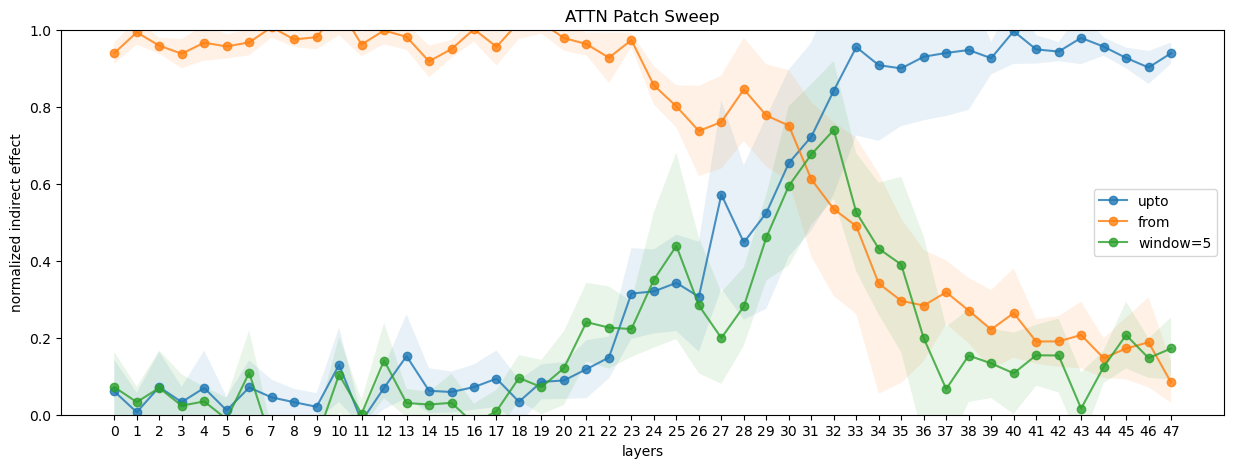

In [17]:
from src.utils.metrics import AggregateMetric

def process_patching_results(
    results: list[dict],
) -> dict[int, AggregateMetric]:

    layers = results[0]["patching_results"].keys()
    layers = sorted(layers)

    layerwise_results = {l: [] for l in layers}
    for sample in results:
        gold_score = sample["gold_score"]
        corrupt_score = sample["corrupt_score"]
        for layer_idx in layers:
            score = sample["patching_results"][layer_idx]["score"]
            layerwise_results[layer_idx].append(
                (score - corrupt_score) / (gold_score - corrupt_score)
            )

    return {l: AggregateMetric.aggregate(v) for l, v in layerwise_results.items()}


from matplotlib import pyplot as plt
import numpy as np

def plot_results(results, canvas, set_canvas_layout = True, label = None):

    layers, values = zip(*results.items())

    means = np.array([v.mean for v in values])
    stds = np.array([v.stderr for v in values])

    canvas.plot(means, marker="o", linewidth=1.5, label = label, alpha = 0.8)
    canvas.fill_between(layers, means - stds, means + stds, alpha=0.1)

    if set_canvas_layout:
        canvas.ylim(bottom=0, top=1)
        canvas.xticks(layers)
        canvas.title(f"ATTN Patch Sweep")
        canvas.ylabel("normalized indirect effect")
        canvas.xlabel("layers")


plt.figure(figsize=(15, 5))

processed_results_upto = process_patching_results(res_upto)
plot_results(processed_results_upto, plt, set_canvas_layout=True, label="upto")

processed_results_from = process_patching_results(res_from)
plot_results(processed_results_from, plt, set_canvas_layout=False, label="from" )

processed_results_win = process_patching_results(res_win)
plot_results(processed_results_win, plt, set_canvas_layout=False, label="window=5")

plt.legend()

plt.show()

In [18]:
kwargs = dict(
    mt = mt,
    # samples = [coincidences["examples"][sample_idx]],
    samples = coincidences["examples"],
    token_idx = -1,
    metric = "logit",
    coeff = 1.0,
    kind = "mlp",
)

mlp_res_from = do_patching_sweep(
    **kwargs,
    window = "from",
)

mlp_res_upto = do_patching_sweep(
    **kwargs,
    window = "upto",
)

mlp_res_win = do_patching_sweep(
    **kwargs,
    window = 5,
)

0it [00:00, ?it/s]

2025-04-07 17:11:14 __main__ INFO     (1/13)  sample['entity_pair']=['Germany', 'Japan'] <-- Korea
2025-04-07 17:11:20 __main__ INFO     ['Germany', 'Japan'] >> answer='Axis powers in World War II.'
2025-04-07 17:11:25 __main__ INFO     ('Korea', 'Japan') >> clean_answer='part of the Japanese Empire.'
2025-04-07 17:11:25 __main__ INFO     ['34474( Axis)', '13430( powers)', '4337( World)', '5004( War)', '7946( II)']
2025-04-07 17:11:25 __main__ INFO     gold_score=12.6796875
2025-04-07 17:11:26 __main__ INFO     corrupt_score=9.96875
2025-04-07 17:11:26 __main__ DEBUG             layer_idx=0, patched_score=12.125
2025-04-07 17:11:26 __main__ DEBUG             layer_idx=1, patched_score=12.1328125
2025-04-07 17:11:26 __main__ DEBUG             layer_idx=2, patched_score=12.125
2025-04-07 17:11:26 __main__ DEBUG             layer_idx=3, patched_score=12.125
2025-04-07 17:11:27 __main__ DEBUG             layer_idx=4, patched_score=12.1171875
2025-04-07 17:11:27 __main__ DEBUG             l

1it [00:19, 19.75s/it]

2025-04-07 17:11:34 __main__ INFO     (2/13)  sample['entity_pair']=['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2025-04-07 17:11:39 __main__ INFO     ['Hugh Jackman', 'Ryan Reynolds'] >> answer='actors and friends.'
2025-04-07 17:11:45 __main__ INFO     ('Celine Dion', 'Ryan Reynolds') >> clean_answer='married to the same person.'
2025-04-07 17:11:45 __main__ INFO     ['19571( actors)', '4780( friends)']
2025-04-07 17:11:45 __main__ INFO     gold_score=17.328125
2025-04-07 17:11:45 __main__ INFO     corrupt_score=15.515625
2025-04-07 17:11:46 __main__ DEBUG             layer_idx=0, patched_score=16.359375
2025-04-07 17:11:46 __main__ DEBUG             layer_idx=1, patched_score=16.34375
2025-04-07 17:11:46 __main__ DEBUG             layer_idx=2, patched_score=16.34375
2025-04-07 17:11:46 __main__ DEBUG             layer_idx=3, patched_score=16.359375
2025-04-07 17:11:46 __main__ DEBUG             layer_idx=4, patched_score=16.34375
2025-04-07 17:11:47 __main__ DEBUG             l

2it [00:39, 19.90s/it]

2025-04-07 17:11:54 __main__ INFO     (3/13)  sample['entity_pair']=['Bhutan', 'Nepal'] <-- India
2025-04-07 17:12:00 __main__ INFO     ['Bhutan', 'Nepal'] >> answer='monarchies.'
2025-04-07 17:12:05 __main__ INFO     ('India', 'Nepal') >> clean_answer='ruled by the British Empire.'
2025-04-07 17:12:05 __main__ INFO     ['62754( monarch)']
2025-04-07 17:12:05 __main__ INFO     gold_score=18.71875
2025-04-07 17:12:06 __main__ INFO     corrupt_score=15.578125
2025-04-07 17:12:06 __main__ DEBUG             layer_idx=0, patched_score=17.546875
2025-04-07 17:12:06 __main__ DEBUG             layer_idx=1, patched_score=17.515625
2025-04-07 17:12:06 __main__ DEBUG             layer_idx=2, patched_score=17.53125
2025-04-07 17:12:06 __main__ DEBUG             layer_idx=3, patched_score=17.5625
2025-04-07 17:12:07 __main__ DEBUG             layer_idx=4, patched_score=17.53125
2025-04-07 17:12:07 __main__ DEBUG             layer_idx=5, patched_score=17.546875
2025-04-07 17:12:07 __main__ DEBUG    

3it [00:59, 20.05s/it]

2025-04-07 17:12:14 __main__ INFO     (4/13)  sample['entity_pair']=['Mount Athos', 'Vatican City'] <-- Italy
2025-04-07 17:12:20 __main__ INFO     ['Mount Athos', 'Vatican City'] >> answer='ruled by the Byzantine Empire.'
2025-04-07 17:12:25 __main__ INFO     ('Italy', 'Vatican City') >> clean_answer='ruled by the Pope.'
2025-04-07 17:12:25 __main__ INFO     ['21286( ruled)', '81660( Byz)', '20448( Empire)']
2025-04-07 17:12:26 __main__ INFO     gold_score=11.4453125
2025-04-07 17:12:26 __main__ INFO     corrupt_score=11.9375
2025-04-07 17:12:26 __main__ DEBUG             layer_idx=0, patched_score=11.703125
2025-04-07 17:12:26 __main__ DEBUG             layer_idx=1, patched_score=11.734375
2025-04-07 17:12:27 __main__ DEBUG             layer_idx=2, patched_score=11.7109375
2025-04-07 17:12:27 __main__ DEBUG             layer_idx=3, patched_score=11.7109375
2025-04-07 17:12:27 __main__ DEBUG             layer_idx=4, patched_score=11.703125
2025-04-07 17:12:27 __main__ DEBUG           

4it [01:20, 20.17s/it]

2025-04-07 17:12:35 __main__ INFO     (5/13)  sample['entity_pair']=['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
2025-04-07 17:12:40 __main__ INFO     ['Dead Sea Scrolls', 'Rosetta Stone'] >> answer='important historical artifacts.'
2025-04-07 17:12:46 __main__ INFO     ('Pyramid of Giza', 'Rosetta Stone') >> clean_answer='located in Egypt.'
2025-04-07 17:12:46 __main__ INFO     ['2989( important)', '13656( historical)', '35036( artifacts)']
2025-04-07 17:12:46 __main__ INFO     gold_score=17.75
2025-04-07 17:12:46 __main__ INFO     corrupt_score=17.9375
2025-04-07 17:12:46 __main__ DEBUG             layer_idx=0, patched_score=17.46875
2025-04-07 17:12:47 __main__ DEBUG             layer_idx=1, patched_score=17.46875
2025-04-07 17:12:47 __main__ DEBUG             layer_idx=2, patched_score=17.453125
2025-04-07 17:12:47 __main__ DEBUG             layer_idx=3, patched_score=17.453125
2025-04-07 17:12:47 __main__ DEBUG             layer_idx=4, patched_score=17.46875
2025-04-0

5it [01:40, 20.24s/it]

2025-04-07 17:12:55 __main__ INFO     (6/13)  sample['entity_pair']=['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
2025-04-07 17:13:01 __main__ INFO     ['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
2025-04-07 17:13:06 __main__ INFO     ('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'
2025-04-07 17:13:06 __main__ INFO     ['44933( polym)']
2025-04-07 17:13:06 __main__ INFO     gold_score=19.671875
2025-04-07 17:13:07 __main__ INFO     corrupt_score=11.703125
2025-04-07 17:13:07 __main__ DEBUG             layer_idx=0, patched_score=18.625
2025-04-07 17:13:07 __main__ DEBUG             layer_idx=1, patched_score=18.625
2025-04-07 17:13:07 __main__ DEBUG             layer_idx=2, patched_score=18.625
2025-04-07 17:13:07 __main__ DEBUG             layer_idx=3, patched_score=18.609375
2025-04-07 17:13:08 __main__ DEBUG             layer_idx=4, patched_score=18.625
2025-04-07 17:13:08 __main__ DEBUG             layer_idx=

6it [02:01, 20.27s/it]

2025-04-07 17:13:15 __main__ INFO     (7/13)  sample['entity_pair']=['Toph Beifong', 'Daredevil'] <-- Punisher
2025-04-07 17:13:21 __main__ INFO     ['Toph Beifong', 'Daredevil'] >> answer='blind and have superhuman abilities.'
2025-04-07 17:13:26 __main__ INFO     ('Punisher', 'Daredevil') >> clean_answer='Marvel comic book characters.'
2025-04-07 17:13:26 __main__ INFO     ['18020( blind)', '2256( super)', '17541( abilities)']
2025-04-07 17:13:27 __main__ INFO     gold_score=14.8828125
2025-04-07 17:13:27 __main__ INFO     corrupt_score=10.4140625
2025-04-07 17:13:27 __main__ DEBUG             layer_idx=0, patched_score=13.0
2025-04-07 17:13:27 __main__ DEBUG             layer_idx=1, patched_score=13.0234375
2025-04-07 17:13:28 __main__ DEBUG             layer_idx=2, patched_score=13.0390625
2025-04-07 17:13:28 __main__ DEBUG             layer_idx=3, patched_score=13.0078125
2025-04-07 17:13:28 __main__ DEBUG             layer_idx=4, patched_score=13.015625
2025-04-07 17:13:28 __main

7it [02:21, 20.27s/it]

2025-04-07 17:13:36 __main__ INFO     (8/13)  sample['entity_pair']=['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
2025-04-07 17:13:41 __main__ INFO     ['Julius Caesar', 'Nepoleon Bonaparte'] >> answer='military leaders.'
2025-04-07 17:13:47 __main__ INFO     ('Victor Hugo', 'Nepoleon Bonaparte') >> clean_answer='French.'
2025-04-07 17:13:47 __main__ INFO     ['6277( military)', '6036( leaders)']
2025-04-07 17:13:47 __main__ INFO     gold_score=18.578125
2025-04-07 17:13:47 __main__ INFO     corrupt_score=14.6953125
2025-04-07 17:13:47 __main__ DEBUG             layer_idx=0, patched_score=16.796875
2025-04-07 17:13:48 __main__ DEBUG             layer_idx=1, patched_score=16.8125
2025-04-07 17:13:48 __main__ DEBUG             layer_idx=2, patched_score=16.796875
2025-04-07 17:13:48 __main__ DEBUG             layer_idx=3, patched_score=16.78125
2025-04-07 17:13:48 __main__ DEBUG             layer_idx=4, patched_score=16.84375
2025-04-07 17:13:48 __main__ DEBUG             layer

8it [02:41, 20.27s/it]

2025-04-07 17:13:56 __main__ INFO     (9/13)  sample['entity_pair']=['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
2025-04-07 17:14:01 __main__ INFO     ['Christopher Columbus', 'Vasco da Gama'] >> answer='explorers.'
2025-04-07 17:14:07 __main__ INFO     ('Christiano Ronaldo', 'Vasco da Gama') >> clean_answer='Portuguese.'
2025-04-07 17:14:07 __main__ INFO     ['47439( explor)']
2025-04-07 17:14:07 __main__ INFO     gold_score=20.671875
2025-04-07 17:14:07 __main__ INFO     corrupt_score=12.9453125
2025-04-07 17:14:08 __main__ DEBUG             layer_idx=0, patched_score=18.671875
2025-04-07 17:14:08 __main__ DEBUG             layer_idx=1, patched_score=18.671875
2025-04-07 17:14:08 __main__ DEBUG             layer_idx=2, patched_score=18.671875
2025-04-07 17:14:08 __main__ DEBUG             layer_idx=3, patched_score=18.640625
2025-04-07 17:14:08 __main__ DEBUG             layer_idx=4, patched_score=18.6875
2025-04-07 17:14:09 __main__ DEBUG             layer_idx=5,

9it [03:01, 20.27s/it]

2025-04-07 17:14:16 __main__ INFO     (10/13)  sample['entity_pair']=['Whale', 'Elephant'] <-- Horse
2025-04-07 17:14:22 __main__ INFO     ['Whale', 'Elephant'] >> answer='mammals.'
2025-04-07 17:14:27 __main__ INFO     ('Horse', 'Elephant') >> clean_answer='used as war animals.'
2025-04-07 17:14:27 __main__ INFO     ['55569( mammals)']
2025-04-07 17:14:27 __main__ INFO     gold_score=18.640625
2025-04-07 17:14:28 __main__ INFO     corrupt_score=15.5703125
2025-04-07 17:14:28 __main__ DEBUG             layer_idx=0, patched_score=17.609375
2025-04-07 17:14:28 __main__ DEBUG             layer_idx=1, patched_score=17.625
2025-04-07 17:14:28 __main__ DEBUG             layer_idx=2, patched_score=17.609375
2025-04-07 17:14:29 __main__ DEBUG             layer_idx=3, patched_score=17.625
2025-04-07 17:14:29 __main__ DEBUG             layer_idx=4, patched_score=17.625
2025-04-07 17:14:29 __main__ DEBUG             layer_idx=5, patched_score=17.640625
2025-04-07 17:14:29 __main__ DEBUG          

10it [03:22, 20.28s/it]

2025-04-07 17:14:37 __main__ INFO     (11/13)  sample['entity_pair']=['jellyfish', 'lobster'] <-- salmon
2025-04-07 17:14:42 __main__ INFO     ['jellyfish', 'lobster'] >> answer='eaten by the same person.'
2025-04-07 17:14:48 __main__ INFO     ('salmon', 'lobster') >> clean_answer='served at the White House.'
2025-04-07 17:14:48 __main__ INFO     ['34561( eaten)', '1697( person)']
2025-04-07 17:14:48 __main__ INFO     gold_score=11.625
2025-04-07 17:14:48 __main__ INFO     corrupt_score=11.5234375
2025-04-07 17:14:48 __main__ DEBUG             layer_idx=0, patched_score=11.796875
2025-04-07 17:14:48 __main__ DEBUG             layer_idx=1, patched_score=11.8046875
2025-04-07 17:14:49 __main__ DEBUG             layer_idx=2, patched_score=11.8203125
2025-04-07 17:14:49 __main__ DEBUG             layer_idx=3, patched_score=11.8125
2025-04-07 17:14:49 __main__ DEBUG             layer_idx=4, patched_score=11.8125
2025-04-07 17:14:49 __main__ DEBUG             layer_idx=5, patched_score=11.82

11it [03:42, 20.36s/it]

2025-04-07 17:14:57 __main__ INFO     (12/13)  sample['entity_pair']=['crocodile', 'shark'] <-- salmon
2025-04-07 17:15:02 __main__ INFO     ['crocodile', 'shark'] >> answer='apex predators.'
2025-04-07 17:15:08 __main__ INFO     ('salmon', 'shark') >> clean_answer='fish.'
2025-04-07 17:15:08 __main__ INFO     ['71527( apex)', '55117( predators)']
2025-04-07 17:15:08 __main__ INFO     gold_score=17.375
2025-04-07 17:15:09 __main__ INFO     corrupt_score=16.3125
2025-04-07 17:15:09 __main__ DEBUG             layer_idx=0, patched_score=16.84375
2025-04-07 17:15:09 __main__ DEBUG             layer_idx=1, patched_score=16.84375
2025-04-07 17:15:09 __main__ DEBUG             layer_idx=2, patched_score=16.828125
2025-04-07 17:15:09 __main__ DEBUG             layer_idx=3, patched_score=16.828125
2025-04-07 17:15:10 __main__ DEBUG             layer_idx=4, patched_score=16.859375
2025-04-07 17:15:10 __main__ DEBUG             layer_idx=5, patched_score=16.796875
2025-04-07 17:15:10 __main__ DEB

12it [04:03, 20.37s/it]

2025-04-07 17:15:17 __main__ INFO     (13/13)  sample['entity_pair']=['spider', 'crab'] <-- lobster
2025-04-07 17:15:23 __main__ INFO     ['spider', 'crab'] >> answer='arthropods.'
2025-04-07 17:15:29 __main__ INFO     ('lobster', 'crab') >> clean_answer='crustaceans.'
2025-04-07 17:15:29 __main__ INFO     ['796( ar)']
2025-04-07 17:15:29 __main__ INFO     gold_score=17.515625
2025-04-07 17:15:29 __main__ INFO     corrupt_score=16.203125
2025-04-07 17:15:29 __main__ DEBUG             layer_idx=0, patched_score=16.875
2025-04-07 17:15:29 __main__ DEBUG             layer_idx=1, patched_score=16.859375
2025-04-07 17:15:30 __main__ DEBUG             layer_idx=2, patched_score=16.828125
2025-04-07 17:15:30 __main__ DEBUG             layer_idx=3, patched_score=16.859375
2025-04-07 17:15:30 __main__ DEBUG             layer_idx=4, patched_score=16.875
2025-04-07 17:15:30 __main__ DEBUG             layer_idx=5, patched_score=16.859375
2025-04-07 17:15:30 __main__ DEBUG             layer_idx=6, 

13it [04:23, 20.26s/it]
0it [00:00, ?it/s]

2025-04-07 17:15:38 __main__ INFO     (1/13)  sample['entity_pair']=['Germany', 'Japan'] <-- Korea
2025-04-07 17:15:43 __main__ INFO     ['Germany', 'Japan'] >> answer='Axis powers in World War II.'
2025-04-07 17:15:49 __main__ INFO     ('Korea', 'Japan') >> clean_answer='part of the Japanese Empire.'
2025-04-07 17:15:49 __main__ INFO     ['34474( Axis)', '13430( powers)', '4337( World)', '5004( War)', '7946( II)']
2025-04-07 17:15:49 __main__ INFO     gold_score=12.6796875
2025-04-07 17:15:49 __main__ INFO     corrupt_score=9.96875
2025-04-07 17:15:49 __main__ DEBUG             layer_idx=0, patched_score=9.859375
2025-04-07 17:15:50 __main__ DEBUG             layer_idx=1, patched_score=9.890625
2025-04-07 17:15:50 __main__ DEBUG             layer_idx=2, patched_score=9.9765625
2025-04-07 17:15:50 __main__ DEBUG             layer_idx=3, patched_score=9.9453125
2025-04-07 17:15:50 __main__ DEBUG             layer_idx=4, patched_score=9.90625
2025-04-07 17:15:50 __main__ DEBUG           

1it [00:20, 20.32s/it]

2025-04-07 17:15:58 __main__ INFO     (2/13)  sample['entity_pair']=['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2025-04-07 17:16:04 __main__ INFO     ['Hugh Jackman', 'Ryan Reynolds'] >> answer='actors and friends.'
2025-04-07 17:16:09 __main__ INFO     ('Celine Dion', 'Ryan Reynolds') >> clean_answer='married to the same person.'
2025-04-07 17:16:09 __main__ INFO     ['19571( actors)', '4780( friends)']
2025-04-07 17:16:09 __main__ INFO     gold_score=17.328125
2025-04-07 17:16:09 __main__ INFO     corrupt_score=15.515625
2025-04-07 17:16:10 __main__ DEBUG             layer_idx=0, patched_score=15.421875
2025-04-07 17:16:10 __main__ DEBUG             layer_idx=1, patched_score=15.515625
2025-04-07 17:16:10 __main__ DEBUG             layer_idx=2, patched_score=15.546875
2025-04-07 17:16:10 __main__ DEBUG             layer_idx=3, patched_score=15.4375
2025-04-07 17:16:11 __main__ DEBUG             layer_idx=4, patched_score=15.484375
2025-04-07 17:16:11 __main__ DEBUG             

2it [00:40, 20.34s/it]

2025-04-07 17:16:18 __main__ INFO     (3/13)  sample['entity_pair']=['Bhutan', 'Nepal'] <-- India
2025-04-07 17:16:24 __main__ INFO     ['Bhutan', 'Nepal'] >> answer='monarchies.'
2025-04-07 17:16:29 __main__ INFO     ('India', 'Nepal') >> clean_answer='ruled by the British Empire.'
2025-04-07 17:16:29 __main__ INFO     ['62754( monarch)']
2025-04-07 17:16:30 __main__ INFO     gold_score=18.71875
2025-04-07 17:16:30 __main__ INFO     corrupt_score=15.578125
2025-04-07 17:16:30 __main__ DEBUG             layer_idx=0, patched_score=15.375
2025-04-07 17:16:30 __main__ DEBUG             layer_idx=1, patched_score=15.359375
2025-04-07 17:16:30 __main__ DEBUG             layer_idx=2, patched_score=14.9609375
2025-04-07 17:16:31 __main__ DEBUG             layer_idx=3, patched_score=15.328125
2025-04-07 17:16:31 __main__ DEBUG             layer_idx=4, patched_score=15.453125
2025-04-07 17:16:31 __main__ DEBUG             layer_idx=5, patched_score=15.40625
2025-04-07 17:16:31 __main__ DEBUG   

3it [01:00, 20.29s/it]

2025-04-07 17:16:39 __main__ INFO     (4/13)  sample['entity_pair']=['Mount Athos', 'Vatican City'] <-- Italy
2025-04-07 17:16:44 __main__ INFO     ['Mount Athos', 'Vatican City'] >> answer='ruled by the Byzantine Empire.'
2025-04-07 17:16:50 __main__ INFO     ('Italy', 'Vatican City') >> clean_answer='ruled by the Pope.'
2025-04-07 17:16:50 __main__ INFO     ['21286( ruled)', '81660( Byz)', '20448( Empire)']
2025-04-07 17:16:50 __main__ INFO     gold_score=11.4453125
2025-04-07 17:16:50 __main__ INFO     corrupt_score=11.9375
2025-04-07 17:16:50 __main__ DEBUG             layer_idx=0, patched_score=12.0859375
2025-04-07 17:16:51 __main__ DEBUG             layer_idx=1, patched_score=12.09375
2025-04-07 17:16:51 __main__ DEBUG             layer_idx=2, patched_score=12.09375
2025-04-07 17:16:51 __main__ DEBUG             layer_idx=3, patched_score=11.9296875
2025-04-07 17:16:51 __main__ DEBUG             layer_idx=4, patched_score=11.9609375
2025-04-07 17:16:51 __main__ DEBUG            

4it [01:21, 20.27s/it]

2025-04-07 17:16:59 __main__ INFO     (5/13)  sample['entity_pair']=['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
2025-04-07 17:17:04 __main__ INFO     ['Dead Sea Scrolls', 'Rosetta Stone'] >> answer='important historical artifacts.'
2025-04-07 17:17:10 __main__ INFO     ('Pyramid of Giza', 'Rosetta Stone') >> clean_answer='located in Egypt.'
2025-04-07 17:17:10 __main__ INFO     ['2989( important)', '13656( historical)', '35036( artifacts)']
2025-04-07 17:17:10 __main__ INFO     gold_score=17.75
2025-04-07 17:17:10 __main__ INFO     corrupt_score=17.9375
2025-04-07 17:17:10 __main__ DEBUG             layer_idx=0, patched_score=18.0
2025-04-07 17:17:10 __main__ DEBUG             layer_idx=1, patched_score=17.828125
2025-04-07 17:17:11 __main__ DEBUG             layer_idx=2, patched_score=17.765625
2025-04-07 17:17:11 __main__ DEBUG             layer_idx=3, patched_score=17.796875
2025-04-07 17:17:11 __main__ DEBUG             layer_idx=4, patched_score=17.890625
2025-04-07 

5it [01:40, 20.08s/it]

2025-04-07 17:17:19 __main__ INFO     (6/13)  sample['entity_pair']=['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
2025-04-07 17:17:24 __main__ INFO     ['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
2025-04-07 17:17:29 __main__ INFO     ('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'
2025-04-07 17:17:29 __main__ INFO     ['44933( polym)']
2025-04-07 17:17:30 __main__ INFO     gold_score=19.671875
2025-04-07 17:17:30 __main__ INFO     corrupt_score=11.703125
2025-04-07 17:17:30 __main__ DEBUG             layer_idx=0, patched_score=11.640625
2025-04-07 17:17:30 __main__ DEBUG             layer_idx=1, patched_score=11.7265625
2025-04-07 17:17:30 __main__ DEBUG             layer_idx=2, patched_score=11.796875
2025-04-07 17:17:31 __main__ DEBUG             layer_idx=3, patched_score=11.7421875
2025-04-07 17:17:31 __main__ DEBUG             layer_idx=4, patched_score=11.703125
2025-04-07 17:17:31 __main__ DEBUG         

6it [02:00, 19.98s/it]

2025-04-07 17:17:38 __main__ INFO     (7/13)  sample['entity_pair']=['Toph Beifong', 'Daredevil'] <-- Punisher
2025-04-07 17:17:44 __main__ INFO     ['Toph Beifong', 'Daredevil'] >> answer='blind and have superhuman abilities.'
2025-04-07 17:17:49 __main__ INFO     ('Punisher', 'Daredevil') >> clean_answer='Marvel comic book characters.'
2025-04-07 17:17:49 __main__ INFO     ['18020( blind)', '2256( super)', '17541( abilities)']
2025-04-07 17:17:49 __main__ INFO     gold_score=14.8828125
2025-04-07 17:17:50 __main__ INFO     corrupt_score=10.4140625
2025-04-07 17:17:50 __main__ DEBUG             layer_idx=0, patched_score=10.375
2025-04-07 17:17:50 __main__ DEBUG             layer_idx=1, patched_score=10.34375
2025-04-07 17:17:50 __main__ DEBUG             layer_idx=2, patched_score=10.3671875
2025-04-07 17:17:50 __main__ DEBUG             layer_idx=3, patched_score=10.3515625
2025-04-07 17:17:51 __main__ DEBUG             layer_idx=4, patched_score=10.390625
2025-04-07 17:17:51 __main

7it [02:20, 19.96s/it]

2025-04-07 17:17:58 __main__ INFO     (8/13)  sample['entity_pair']=['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
2025-04-07 17:18:04 __main__ INFO     ['Julius Caesar', 'Nepoleon Bonaparte'] >> answer='military leaders.'
2025-04-07 17:18:09 __main__ INFO     ('Victor Hugo', 'Nepoleon Bonaparte') >> clean_answer='French.'
2025-04-07 17:18:09 __main__ INFO     ['6277( military)', '6036( leaders)']
2025-04-07 17:18:09 __main__ INFO     gold_score=18.578125
2025-04-07 17:18:09 __main__ INFO     corrupt_score=14.6953125
2025-04-07 17:18:10 __main__ DEBUG             layer_idx=0, patched_score=14.59375
2025-04-07 17:18:10 __main__ DEBUG             layer_idx=1, patched_score=14.625
2025-04-07 17:18:10 __main__ DEBUG             layer_idx=2, patched_score=14.640625
2025-04-07 17:18:10 __main__ DEBUG             layer_idx=3, patched_score=14.859375
2025-04-07 17:18:10 __main__ DEBUG             layer_idx=4, patched_score=14.609375
2025-04-07 17:18:11 __main__ DEBUG             layer

8it [02:40, 19.93s/it]

2025-04-07 17:18:18 __main__ INFO     (9/13)  sample['entity_pair']=['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
2025-04-07 17:18:24 __main__ INFO     ['Christopher Columbus', 'Vasco da Gama'] >> answer='explorers.'
2025-04-07 17:18:29 __main__ INFO     ('Christiano Ronaldo', 'Vasco da Gama') >> clean_answer='Portuguese.'
2025-04-07 17:18:29 __main__ INFO     ['47439( explor)']
2025-04-07 17:18:29 __main__ INFO     gold_score=20.671875
2025-04-07 17:18:29 __main__ INFO     corrupt_score=12.9453125
2025-04-07 17:18:30 __main__ DEBUG             layer_idx=0, patched_score=12.9296875
2025-04-07 17:18:30 __main__ DEBUG             layer_idx=1, patched_score=12.8515625
2025-04-07 17:18:30 __main__ DEBUG             layer_idx=2, patched_score=13.1171875
2025-04-07 17:18:30 __main__ DEBUG             layer_idx=3, patched_score=12.9453125
2025-04-07 17:18:30 __main__ DEBUG             layer_idx=4, patched_score=12.78125
2025-04-07 17:18:31 __main__ DEBUG             layer_i

9it [03:00, 19.99s/it]

2025-04-07 17:18:38 __main__ INFO     (10/13)  sample['entity_pair']=['Whale', 'Elephant'] <-- Horse
2025-04-07 17:18:44 __main__ INFO     ['Whale', 'Elephant'] >> answer='mammals.'
2025-04-07 17:18:49 __main__ INFO     ('Horse', 'Elephant') >> clean_answer='used as war animals.'
2025-04-07 17:18:49 __main__ INFO     ['55569( mammals)']
2025-04-07 17:18:49 __main__ INFO     gold_score=18.640625
2025-04-07 17:18:49 __main__ INFO     corrupt_score=15.5703125
2025-04-07 17:18:50 __main__ DEBUG             layer_idx=0, patched_score=15.609375
2025-04-07 17:18:50 __main__ DEBUG             layer_idx=1, patched_score=15.5859375
2025-04-07 17:18:50 __main__ DEBUG             layer_idx=2, patched_score=15.6328125
2025-04-07 17:18:50 __main__ DEBUG             layer_idx=3, patched_score=15.6171875
2025-04-07 17:18:50 __main__ DEBUG             layer_idx=4, patched_score=15.421875
2025-04-07 17:18:51 __main__ DEBUG             layer_idx=5, patched_score=15.6171875
2025-04-07 17:18:51 __main__ DE

10it [03:20, 19.99s/it]

2025-04-07 17:18:58 __main__ INFO     (11/13)  sample['entity_pair']=['jellyfish', 'lobster'] <-- salmon
2025-04-07 17:19:04 __main__ INFO     ['jellyfish', 'lobster'] >> answer='eaten by the same person.'
2025-04-07 17:19:09 __main__ INFO     ('salmon', 'lobster') >> clean_answer='served at the White House.'
2025-04-07 17:19:09 __main__ INFO     ['34561( eaten)', '1697( person)']
2025-04-07 17:19:09 __main__ INFO     gold_score=11.625
2025-04-07 17:19:10 __main__ INFO     corrupt_score=11.5234375
2025-04-07 17:19:10 __main__ DEBUG             layer_idx=0, patched_score=11.484375
2025-04-07 17:19:10 __main__ DEBUG             layer_idx=1, patched_score=11.6171875
2025-04-07 17:19:10 __main__ DEBUG             layer_idx=2, patched_score=11.5625
2025-04-07 17:19:10 __main__ DEBUG             layer_idx=3, patched_score=11.4375
2025-04-07 17:19:11 __main__ DEBUG             layer_idx=4, patched_score=11.578125
2025-04-07 17:19:11 __main__ DEBUG             layer_idx=5, patched_score=11.546

11it [03:40, 19.98s/it]

2025-04-07 17:19:18 __main__ INFO     (12/13)  sample['entity_pair']=['crocodile', 'shark'] <-- salmon
2025-04-07 17:19:24 __main__ INFO     ['crocodile', 'shark'] >> answer='apex predators.'
2025-04-07 17:19:29 __main__ INFO     ('salmon', 'shark') >> clean_answer='fish.'
2025-04-07 17:19:29 __main__ INFO     ['71527( apex)', '55117( predators)']
2025-04-07 17:19:30 __main__ INFO     gold_score=17.375
2025-04-07 17:19:30 __main__ INFO     corrupt_score=16.3125
2025-04-07 17:19:30 __main__ DEBUG             layer_idx=0, patched_score=16.140625
2025-04-07 17:19:30 __main__ DEBUG             layer_idx=1, patched_score=16.25
2025-04-07 17:19:30 __main__ DEBUG             layer_idx=2, patched_score=16.15625
2025-04-07 17:19:31 __main__ DEBUG             layer_idx=3, patched_score=16.34375
2025-04-07 17:19:31 __main__ DEBUG             layer_idx=4, patched_score=16.21875
2025-04-07 17:19:31 __main__ DEBUG             layer_idx=5, patched_score=16.140625
2025-04-07 17:19:31 __main__ DEBUG   

12it [04:00, 20.08s/it]

2025-04-07 17:19:39 __main__ INFO     (13/13)  sample['entity_pair']=['spider', 'crab'] <-- lobster
2025-04-07 17:19:44 __main__ INFO     ['spider', 'crab'] >> answer='arthropods.'
2025-04-07 17:19:50 __main__ INFO     ('lobster', 'crab') >> clean_answer='crustaceans.'
2025-04-07 17:19:50 __main__ INFO     ['796( ar)']
2025-04-07 17:19:50 __main__ INFO     gold_score=17.515625
2025-04-07 17:19:50 __main__ INFO     corrupt_score=16.203125
2025-04-07 17:19:50 __main__ DEBUG             layer_idx=0, patched_score=16.140625
2025-04-07 17:19:51 __main__ DEBUG             layer_idx=1, patched_score=16.15625
2025-04-07 17:19:51 __main__ DEBUG             layer_idx=2, patched_score=15.875
2025-04-07 17:19:51 __main__ DEBUG             layer_idx=3, patched_score=16.21875
2025-04-07 17:19:51 __main__ DEBUG             layer_idx=4, patched_score=16.203125
2025-04-07 17:19:51 __main__ DEBUG             layer_idx=5, patched_score=15.984375
2025-04-07 17:19:51 __main__ DEBUG             layer_idx=6,

13it [04:21, 20.09s/it]
0it [00:00, ?it/s]

2025-04-07 17:19:59 __main__ INFO     (1/13)  sample['entity_pair']=['Germany', 'Japan'] <-- Korea
2025-04-07 17:20:04 __main__ INFO     ['Germany', 'Japan'] >> answer='Axis powers in World War II.'
2025-04-07 17:20:10 __main__ INFO     ('Korea', 'Japan') >> clean_answer='part of the Japanese Empire.'
2025-04-07 17:20:10 __main__ INFO     ['34474( Axis)', '13430( powers)', '4337( World)', '5004( War)', '7946( II)']
2025-04-07 17:20:10 __main__ INFO     gold_score=12.6796875
2025-04-07 17:20:10 __main__ INFO     corrupt_score=9.96875
2025-04-07 17:20:11 __main__ DEBUG             layer_idx=0, patched_score=9.9765625
2025-04-07 17:20:11 __main__ DEBUG             layer_idx=1, patched_score=9.9453125
2025-04-07 17:20:11 __main__ DEBUG             layer_idx=2, patched_score=9.90625
2025-04-07 17:20:11 __main__ DEBUG             layer_idx=3, patched_score=10.0
2025-04-07 17:20:11 __main__ DEBUG             layer_idx=4, patched_score=10.0546875
2025-04-07 17:20:12 __main__ DEBUG             

1it [00:19, 19.95s/it]

2025-04-07 17:20:19 __main__ INFO     (2/13)  sample['entity_pair']=['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2025-04-07 17:20:24 __main__ INFO     ['Hugh Jackman', 'Ryan Reynolds'] >> answer='actors and friends.'
2025-04-07 17:20:30 __main__ INFO     ('Celine Dion', 'Ryan Reynolds') >> clean_answer='married to the same person.'
2025-04-07 17:20:30 __main__ INFO     ['19571( actors)', '4780( friends)']
2025-04-07 17:20:30 __main__ INFO     gold_score=17.328125
2025-04-07 17:20:30 __main__ INFO     corrupt_score=15.515625
2025-04-07 17:20:31 __main__ DEBUG             layer_idx=0, patched_score=15.546875
2025-04-07 17:20:31 __main__ DEBUG             layer_idx=1, patched_score=15.4375
2025-04-07 17:20:31 __main__ DEBUG             layer_idx=2, patched_score=15.484375
2025-04-07 17:20:31 __main__ DEBUG             layer_idx=3, patched_score=15.3984375
2025-04-07 17:20:31 __main__ DEBUG             layer_idx=4, patched_score=15.453125
2025-04-07 17:20:32 __main__ DEBUG            

2it [00:39, 20.01s/it]

2025-04-07 17:20:39 __main__ INFO     (3/13)  sample['entity_pair']=['Bhutan', 'Nepal'] <-- India
2025-04-07 17:20:44 __main__ INFO     ['Bhutan', 'Nepal'] >> answer='monarchies.'
2025-04-07 17:20:50 __main__ INFO     ('India', 'Nepal') >> clean_answer='ruled by the British Empire.'
2025-04-07 17:20:50 __main__ INFO     ['62754( monarch)']
2025-04-07 17:20:50 __main__ INFO     gold_score=18.71875
2025-04-07 17:20:50 __main__ INFO     corrupt_score=15.578125
2025-04-07 17:20:51 __main__ DEBUG             layer_idx=0, patched_score=14.9609375
2025-04-07 17:20:51 __main__ DEBUG             layer_idx=1, patched_score=15.328125
2025-04-07 17:20:51 __main__ DEBUG             layer_idx=2, patched_score=15.453125
2025-04-07 17:20:51 __main__ DEBUG             layer_idx=3, patched_score=15.3984375
2025-04-07 17:20:51 __main__ DEBUG             layer_idx=4, patched_score=15.203125
2025-04-07 17:20:52 __main__ DEBUG             layer_idx=5, patched_score=15.3046875
2025-04-07 17:20:52 __main__ DE

3it [00:59, 19.98s/it]

2025-04-07 17:20:59 __main__ INFO     (4/13)  sample['entity_pair']=['Mount Athos', 'Vatican City'] <-- Italy
2025-04-07 17:21:04 __main__ INFO     ['Mount Athos', 'Vatican City'] >> answer='ruled by the Byzantine Empire.'
2025-04-07 17:21:10 __main__ INFO     ('Italy', 'Vatican City') >> clean_answer='ruled by the Pope.'
2025-04-07 17:21:10 __main__ INFO     ['21286( ruled)', '81660( Byz)', '20448( Empire)']
2025-04-07 17:21:10 __main__ INFO     gold_score=11.4453125
2025-04-07 17:21:10 __main__ INFO     corrupt_score=11.9375
2025-04-07 17:21:11 __main__ DEBUG             layer_idx=0, patched_score=12.09375
2025-04-07 17:21:11 __main__ DEBUG             layer_idx=1, patched_score=11.9296875
2025-04-07 17:21:11 __main__ DEBUG             layer_idx=2, patched_score=11.9609375
2025-04-07 17:21:11 __main__ DEBUG             layer_idx=3, patched_score=11.8828125
2025-04-07 17:21:11 __main__ DEBUG             layer_idx=4, patched_score=12.0703125
2025-04-07 17:21:12 __main__ DEBUG          

4it [01:19, 19.97s/it]

2025-04-07 17:21:19 __main__ INFO     (5/13)  sample['entity_pair']=['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
2025-04-07 17:21:24 __main__ INFO     ['Dead Sea Scrolls', 'Rosetta Stone'] >> answer='important historical artifacts.'
2025-04-07 17:21:30 __main__ INFO     ('Pyramid of Giza', 'Rosetta Stone') >> clean_answer='located in Egypt.'
2025-04-07 17:21:30 __main__ INFO     ['2989( important)', '13656( historical)', '35036( artifacts)']
2025-04-07 17:21:30 __main__ INFO     gold_score=17.75
2025-04-07 17:21:30 __main__ INFO     corrupt_score=17.9375
2025-04-07 17:21:31 __main__ DEBUG             layer_idx=0, patched_score=17.765625
2025-04-07 17:21:31 __main__ DEBUG             layer_idx=1, patched_score=17.796875
2025-04-07 17:21:31 __main__ DEBUG             layer_idx=2, patched_score=17.890625
2025-04-07 17:21:31 __main__ DEBUG             layer_idx=3, patched_score=17.890625
2025-04-07 17:21:31 __main__ DEBUG             layer_idx=4, patched_score=17.96875
2025-04

5it [01:39, 20.02s/it]

2025-04-07 17:21:39 __main__ INFO     (6/13)  sample['entity_pair']=['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
2025-04-07 17:21:44 __main__ INFO     ['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
2025-04-07 17:21:50 __main__ INFO     ('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'
2025-04-07 17:21:50 __main__ INFO     ['44933( polym)']
2025-04-07 17:21:50 __main__ INFO     gold_score=19.671875
2025-04-07 17:21:50 __main__ INFO     corrupt_score=11.703125
2025-04-07 17:21:51 __main__ DEBUG             layer_idx=0, patched_score=11.796875
2025-04-07 17:21:51 __main__ DEBUG             layer_idx=1, patched_score=11.7421875
2025-04-07 17:21:51 __main__ DEBUG             layer_idx=2, patched_score=11.703125
2025-04-07 17:21:51 __main__ DEBUG             layer_idx=3, patched_score=11.5390625
2025-04-07 17:21:51 __main__ DEBUG             layer_idx=4, patched_score=11.734375
2025-04-07 17:21:52 __main__ DEBUG         

6it [02:00, 20.02s/it]

2025-04-07 17:21:59 __main__ INFO     (7/13)  sample['entity_pair']=['Toph Beifong', 'Daredevil'] <-- Punisher
2025-04-07 17:22:04 __main__ INFO     ['Toph Beifong', 'Daredevil'] >> answer='blind and have superhuman abilities.'
2025-04-07 17:22:10 __main__ INFO     ('Punisher', 'Daredevil') >> clean_answer='Marvel comic book characters.'
2025-04-07 17:22:10 __main__ INFO     ['18020( blind)', '2256( super)', '17541( abilities)']
2025-04-07 17:22:10 __main__ INFO     gold_score=14.8828125
2025-04-07 17:22:10 __main__ INFO     corrupt_score=10.4140625
2025-04-07 17:22:11 __main__ DEBUG             layer_idx=0, patched_score=10.3671875
2025-04-07 17:22:11 __main__ DEBUG             layer_idx=1, patched_score=10.3515625
2025-04-07 17:22:11 __main__ DEBUG             layer_idx=2, patched_score=10.390625
2025-04-07 17:22:11 __main__ DEBUG             layer_idx=3, patched_score=10.40625
2025-04-07 17:22:11 __main__ DEBUG             layer_idx=4, patched_score=10.4296875
2025-04-07 17:22:12 __

7it [02:20, 20.01s/it]

2025-04-07 17:22:19 __main__ INFO     (8/13)  sample['entity_pair']=['Julius Caesar', 'Nepoleon Bonaparte'] <-- Victor Hugo
2025-04-07 17:22:24 __main__ INFO     ['Julius Caesar', 'Nepoleon Bonaparte'] >> answer='military leaders.'
2025-04-07 17:22:30 __main__ INFO     ('Victor Hugo', 'Nepoleon Bonaparte') >> clean_answer='French.'
2025-04-07 17:22:30 __main__ INFO     ['6277( military)', '6036( leaders)']
2025-04-07 17:22:30 __main__ INFO     gold_score=18.578125
2025-04-07 17:22:30 __main__ INFO     corrupt_score=14.6953125
2025-04-07 17:22:31 __main__ DEBUG             layer_idx=0, patched_score=14.640625
2025-04-07 17:22:31 __main__ DEBUG             layer_idx=1, patched_score=14.859375
2025-04-07 17:22:31 __main__ DEBUG             layer_idx=2, patched_score=14.609375
2025-04-07 17:22:31 __main__ DEBUG             layer_idx=3, patched_score=14.7734375
2025-04-07 17:22:31 __main__ DEBUG             layer_idx=4, patched_score=14.6875
2025-04-07 17:22:32 __main__ DEBUG             la

8it [02:40, 20.04s/it]

2025-04-07 17:22:39 __main__ INFO     (9/13)  sample['entity_pair']=['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
2025-04-07 17:22:45 __main__ INFO     ['Christopher Columbus', 'Vasco da Gama'] >> answer='explorers.'
2025-04-07 17:22:50 __main__ INFO     ('Christiano Ronaldo', 'Vasco da Gama') >> clean_answer='Portuguese.'
2025-04-07 17:22:50 __main__ INFO     ['47439( explor)']
2025-04-07 17:22:50 __main__ INFO     gold_score=20.671875
2025-04-07 17:22:50 __main__ INFO     corrupt_score=12.9453125
2025-04-07 17:22:51 __main__ DEBUG             layer_idx=0, patched_score=13.1171875
2025-04-07 17:22:51 __main__ DEBUG             layer_idx=1, patched_score=12.9453125
2025-04-07 17:22:51 __main__ DEBUG             layer_idx=2, patched_score=12.78125
2025-04-07 17:22:51 __main__ DEBUG             layer_idx=3, patched_score=13.0859375
2025-04-07 17:22:51 __main__ DEBUG             layer_idx=4, patched_score=13.078125
2025-04-07 17:22:52 __main__ DEBUG             layer_id

9it [03:00, 20.03s/it]

2025-04-07 17:22:59 __main__ INFO     (10/13)  sample['entity_pair']=['Whale', 'Elephant'] <-- Horse
2025-04-07 17:23:05 __main__ INFO     ['Whale', 'Elephant'] >> answer='mammals.'
2025-04-07 17:23:10 __main__ INFO     ('Horse', 'Elephant') >> clean_answer='used as war animals.'
2025-04-07 17:23:10 __main__ INFO     ['55569( mammals)']
2025-04-07 17:23:10 __main__ INFO     gold_score=18.640625
2025-04-07 17:23:10 __main__ INFO     corrupt_score=15.5703125
2025-04-07 17:23:11 __main__ DEBUG             layer_idx=0, patched_score=15.6328125
2025-04-07 17:23:11 __main__ DEBUG             layer_idx=1, patched_score=15.6171875
2025-04-07 17:23:11 __main__ DEBUG             layer_idx=2, patched_score=15.421875
2025-04-07 17:23:11 __main__ DEBUG             layer_idx=3, patched_score=15.4765625
2025-04-07 17:23:11 __main__ DEBUG             layer_idx=4, patched_score=15.765625
2025-04-07 17:23:12 __main__ DEBUG             layer_idx=5, patched_score=15.6953125
2025-04-07 17:23:12 __main__ DE

10it [03:20, 19.98s/it]

2025-04-07 17:23:19 __main__ INFO     (11/13)  sample['entity_pair']=['jellyfish', 'lobster'] <-- salmon
2025-04-07 17:23:25 __main__ INFO     ['jellyfish', 'lobster'] >> answer='eaten by the same person.'
2025-04-07 17:23:30 __main__ INFO     ('salmon', 'lobster') >> clean_answer='served at the White House.'
2025-04-07 17:23:30 __main__ INFO     ['34561( eaten)', '1697( person)']
2025-04-07 17:23:30 __main__ INFO     gold_score=11.625
2025-04-07 17:23:30 __main__ INFO     corrupt_score=11.5234375
2025-04-07 17:23:31 __main__ DEBUG             layer_idx=0, patched_score=11.5625
2025-04-07 17:23:31 __main__ DEBUG             layer_idx=1, patched_score=11.4375
2025-04-07 17:23:31 __main__ DEBUG             layer_idx=2, patched_score=11.578125
2025-04-07 17:23:31 __main__ DEBUG             layer_idx=3, patched_score=11.59375
2025-04-07 17:23:31 __main__ DEBUG             layer_idx=4, patched_score=11.515625
2025-04-07 17:23:32 __main__ DEBUG             layer_idx=5, patched_score=11.49218

11it [03:40, 20.00s/it]

2025-04-07 17:23:39 __main__ INFO     (12/13)  sample['entity_pair']=['crocodile', 'shark'] <-- salmon
2025-04-07 17:23:45 __main__ INFO     ['crocodile', 'shark'] >> answer='apex predators.'
2025-04-07 17:23:50 __main__ INFO     ('salmon', 'shark') >> clean_answer='fish.'
2025-04-07 17:23:50 __main__ INFO     ['71527( apex)', '55117( predators)']
2025-04-07 17:23:50 __main__ INFO     gold_score=17.375
2025-04-07 17:23:51 __main__ INFO     corrupt_score=16.3125
2025-04-07 17:23:51 __main__ DEBUG             layer_idx=0, patched_score=16.15625
2025-04-07 17:23:51 __main__ DEBUG             layer_idx=1, patched_score=16.34375
2025-04-07 17:23:51 __main__ DEBUG             layer_idx=2, patched_score=16.21875
2025-04-07 17:23:51 __main__ DEBUG             layer_idx=3, patched_score=16.359375
2025-04-07 17:23:52 __main__ DEBUG             layer_idx=4, patched_score=16.171875
2025-04-07 17:23:52 __main__ DEBUG             layer_idx=5, patched_score=16.171875
2025-04-07 17:23:52 __main__ DEBU

12it [04:00, 20.04s/it]

2025-04-07 17:23:59 __main__ INFO     (13/13)  sample['entity_pair']=['spider', 'crab'] <-- lobster
2025-04-07 17:24:05 __main__ INFO     ['spider', 'crab'] >> answer='arthropods.'
2025-04-07 17:24:10 __main__ INFO     ('lobster', 'crab') >> clean_answer='crustaceans.'
2025-04-07 17:24:10 __main__ INFO     ['796( ar)']
2025-04-07 17:24:10 __main__ INFO     gold_score=17.515625
2025-04-07 17:24:10 __main__ INFO     corrupt_score=16.203125
2025-04-07 17:24:11 __main__ DEBUG             layer_idx=0, patched_score=15.875
2025-04-07 17:24:11 __main__ DEBUG             layer_idx=1, patched_score=16.21875
2025-04-07 17:24:11 __main__ DEBUG             layer_idx=2, patched_score=16.203125
2025-04-07 17:24:11 __main__ DEBUG             layer_idx=3, patched_score=16.09375
2025-04-07 17:24:11 __main__ DEBUG             layer_idx=4, patched_score=16.140625
2025-04-07 17:24:12 __main__ DEBUG             layer_idx=5, patched_score=16.0625
2025-04-07 17:24:12 __main__ DEBUG             layer_idx=6, p

13it [04:19, 19.99s/it]


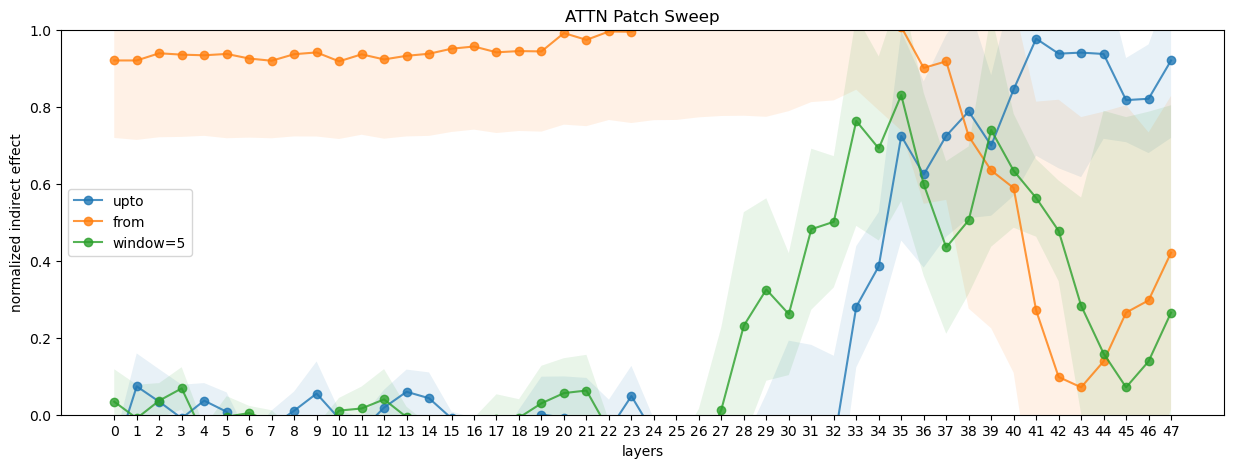

In [19]:
plt.figure(figsize=(15, 5))

processed_results_upto = process_patching_results(mlp_res_upto)
plot_results(processed_results_upto, plt, set_canvas_layout=True, label="upto")

processed_results_from = process_patching_results(mlp_res_from)
plot_results(processed_results_from, plt, set_canvas_layout=False, label="from" )

processed_results_win = process_patching_results(mlp_res_win)
plot_results(processed_results_win, plt, set_canvas_layout=False, label="window=5")

plt.legend()

plt.show()

## What are these heads *looking* back to?

* Attention heads in layers $26 \rightarrow 32$ looks at the `were` token.
    * Hypothesis: hybrid representation is formed here by looking back to the subject tokens. The heads at the last token position just brings this information forward to the last token position.

    Verification Experiments:
    * First check if the patching is effective by just patching the `were` token.
    * From the `were` token position are the heads looking back to the subject tokens now? Sub-hypothesis: MLP shouldn't do anything much here.
    * Forwarding the same information part will be tricky to address though.
    * Can we actually check which things are related vs unrelated just by checking certain properties of the `hybrid` representation?

---
#### Findings:

* Indirect Effect from the `ere` token is strong enough to warrent further investigation?
    * How much of the IE is lost if attn is blocked to the `were` token? ==> Not blocking attention to the `were` token helps, but not that much


In [220]:
# with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
#     coincidences = json.load(f)

# logger.info(f"{len(coincidences['examples'])=}")

In [221]:
# for idx, entities in enumerate(coincidences["examples"]):
#     print(f"{idx} => {entities['entity_pair']}")

In [272]:
sample_idx = 7
sample = coincidences["examples"][sample_idx]
entities = sample["entity_pair"]
sample

{'entity_pair': ['Julius Caesar', 'Nepoleon Bonaparte'],
 'connection': 'military leaders.',
 'alt_first': {'entity': 'Victor Hugo', 'connection': 'French.'}}

In [273]:
from src.functional import get_keywords

mt.reset_forward()

patch_prompt = prepare_probing_input(
    mt=mt,
    entities=sample["entity_pair"],
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both",
    # answer_prefix = " They are both used to say",
    return_offsets_mapping=True
)


answer = get_lm_generated_answer(
    mt=mt, prompt=patch_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["entity_pair"]} >> {answer=}')
keywords = get_keywords(text = answer, tokenizer=mt)
print(f'{[f"{t}({mt.tokenizer.decode(t)})" for t in keywords]}')

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(sample["alt_first"]["entity"], sample["entity_pair"][1]), 
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both",
    return_offsets_mapping=True,
)

clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["alt_first"]["entity"], sample["entity_pair"][1]} >> {clean_answer=}')

['Julius Caesar', 'Nepoleon Bonaparte'] >> answer='military leaders and conquerors.'
['6277( military)', '6036( leaders)', '50530( conquer)']
('Victor Hugo', 'Nepoleon Bonaparte') >> clean_answer='French.'


In [274]:
from src.tokens import align_patching_positions

aligned_prompts = align_patching_positions(
    mt = mt,
    prompt_template = patch_prompt.prompt.replace(patch_prompt.entities[0], "{}"),
    clean_subj = clean_prompt.entities[0],
    patched_subj = patch_prompt.entities[0],
    trace_start_marker="#"
)

aligned_prompts["subj_range"]
# aligned_prompts["clean_input"]

(205, 207)

In [275]:
from src.probing.utils import ProbingPrompt

e1_range = aligned_prompts["subj_range"]

shift = e1_range[1] - clean_prompt.entity_ranges[0][1]

e2_range = clean_prompt.entity_ranges[1]
e2_range = (
    e2_range[0] + shift,
    e2_range[1] + shift
)

tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])
print(f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][e1_range[0] : e1_range[1]])}"')
print(f'"{mt.tokenizer.decode(tokenized_input.input_ids[0][e2_range[0] : e2_range[1]])}"')

tokenized_patch_input = TokenizerOutput(data = aligned_prompts["patched_input"])
print(f'"{mt.tokenizer.decode(tokenized_patch_input.input_ids[0][e1_range[0] : e1_range[1]])}"')

aligned_clean_prompt = ProbingPrompt(
    prompt = mt.tokenizer.decode(aligned_prompts["clean_input"]["input_ids"][0]),
    entities = clean_prompt.entities,

    model_key = clean_prompt.model_key,
    tokenized=aligned_prompts["clean_input"],

    entity_ranges = [e1_range, e2_range],

    query_range=[-1, -1]
)

aligned_patch_prompt = ProbingPrompt(
    prompt = mt.tokenizer.decode(aligned_prompts["patched_input"]["input_ids"][0]),
    entities = patch_prompt.entities,

    model_key = patch_prompt.model_key,
    tokenized=aligned_prompts["patched_input"],

    entity_ranges = [e1_range, e2_range],

    query_range=[-1, -1]
)

" Victor Hugo"
" Nepoleon Bonaparte"
" Julius Caesar"


In [276]:
##################################################
# layer_idx = 30
# layer_window = get_window(mt.attn_module_name_format, layer_idx, 5, mt.n_layer)
# layer_window = range(28, 35)
# layer_window = range(10, 20)
# layer_window = range(40, mt.n_layer-2)
# LAYER_WINDOW = list(range(26, 35))
# LAYER_WINDOW = list(range(0, 10))

PATCH_LAYER_WINDOW = list(range(0, 10))

# METRIC = "logit"
# METRIC = "prob"
METRIC = "log_norm"
##################################################

In [277]:
import itertools
patch_states = get_hs(
    mt = mt,
    input = TokenizerOutput(data = aligned_prompts["patched_input"]),
    # locations = [(mt.layer_name_format.format(l), -2) for l in range(mt.n_layer)],
    locations = list(itertools.product(mt.layer_names, list(range(*aligned_prompts["subj_range"])))),
    return_dict=True
)



gold_score, gold_pred, gold_track = patched_run(
    mt = mt,
    # inputs = TokenizerOutput(data = patch_prompt.tokenized),
    inputs = TokenizerOutput(data = aligned_prompts["patched_input"]),
    patches = [],
    ans_tokens = keywords,
    # generate_full_ans = True,
    metric = METRIC,
)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")

corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt = mt,
    # inputs = TokenizerOutput(data = clean_prompt.tokenized),
    inputs = TokenizerOutput(data = aligned_prompts["clean_input"]),
    patches = [],
    ans_tokens = keywords,
    # generate_full_ans = True,
    metric = METRIC,
)
print(f"{corrupt_score=}")
print(f"{corrupt_pred=}")
print(f"{corrupt_track=}")



# layer_window = [mt.attn_module_name_format.format(l) for l in layer_window]
layer_window = [mt.layer_name_format.format(l) for l in PATCH_LAYER_WINDOW]
# input = TokenizerOutput(data = clean_prompt.tokenized)
# last_tok_idx = input.input_ids.shape[1] - 1

tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])

# for `are/were``
# patches = [
#     PatchSpec(
#         location = (layer, -2),
#         patch = patch_states[(layer, -2)]
#     ) for layer in layer_window
# ]

# for the patched subject
patches = [
    PatchSpec(
        location = (layer, token_idx),
        patch = patch_states[(layer, token_idx)]
    ) for layer, token_idx in itertools.product(layer_window, range(*aligned_prompts["subj_range"]))
]
# patches = []

patched_score, pred, track = patched_run(
    mt = mt,
    inputs = tokenized_input,
    patches = patches,
    ans_tokens = keywords,
    generate_full_ans = True,
    metric = METRIC,
)

print(f"{patched_score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (patched_score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

gold_score=1.03125
gold_pred=[PredictedToken(token=' military', prob=0.263671875, logit=19.0, token_id=6277), PredictedToken(token=' leaders', prob=0.10986328125, logit=18.125, token_id=6036), PredictedToken(token=' famous', prob=0.058837890625, logit=17.5, token_id=11245), PredictedToken(token=' generals', prob=0.052001953125, logit=17.375, token_id=70067), PredictedToken(token=' em', prob=0.052001953125, logit=17.375, token_id=976)]
gold_track={6277: (1, PredictedToken(token=' military', prob=0.263671875, logit=19.0, token_id=6277)), 6036: (2, PredictedToken(token=' leaders', prob=0.10986328125, logit=18.125, token_id=6036)), 50530: (11, PredictedToken(token=' conquer', prob=0.0216064453125, logit=16.5, token_id=50530))}
corrupt_score=0.77734375
corrupt_pred=[PredictedToken(token=' French', prob=0.46484375, logit=19.25, token_id=8585), PredictedToken(token=' famous', prob=0.103515625, logit=17.75, token_id=11245), PredictedToken(token=' from', prob=0.09130859375, logit=17.625, token_

In [278]:
from src.functional import predict_next_token

# predict_next_token(
#     mt = mt,
#     inputs = TokenizerOutput(data = aligned_prompts["clean_input"]),
# )

In [279]:
from src.attention import get_attention_matrices
from src.functional import interpret_logits

# # inputs = TokenizerOutput(data=clean_prompt.tokenized)
# tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])
# print(tokenized_input.input_ids.shape)
# # offset_mapping = tokenized_input.pop("offset_mapping")[0]

# clean_attn = get_attention_matrices(
#     input=tokenized_input,
#     mt = mt,
#     value_weighted=False,
#     # patches = patches
# )

# score = get_score(
#     logits = clean_attn.logits,
#     token_id=keywords,
#     metric = METRIC
# )
# print(f"{score=}")

# indirect_effect = (score - corrupt_score) / (gold_score - corrupt_score)
# print(f"{indirect_effect=}")

# interpret_logits(logits = clean_attn.logits, tokenizer=mt, interested_tokens=keywords)


In [280]:
from src.tokens import find_token_range
from circuitsvis.tokens import colored_tokens
from IPython.display import display, HTML
from src.attention import AttentionInformation

def visualize_average_attn_matrix(
    attn_matrices: dict,
    prompt: ProbingPrompt | str,
    layer_window: list | None = None,
    q_index: int = -1,
    remove_bos: bool = True,
    start_from: int | str | None = None
):
    inputs = TokenizerOutput(data=prompt.tokenized)
    if start_from is None:
        start_from = 1 if remove_bos else 0
    elif isinstance(start_from, str):
        start_from = find_token_range(
            string=prompt.prompt,
            substring="#",
            tokenizer=mt,
            offset_mapping=inputs.offset_mapping[0],
            occurrence=-1
        )[1] - 1

    # print(f"{start_from=}")

    for layer in layer_window:
        print(f"{layer=}")
        if isinstance(attn_matrices, AttentionInformation):
            avg_attn_module_matrix = torch.Tensor(attn_matrices.attention_matrices[layer]).mean(dim=0)[q_index]
        else:
            avg_attn_module_matrix = torch.stack(
                [attn_matrices[layer][h_idx].squeeze() for h_idx in range(mt.config.num_attention_heads)]
            ).mean(dim=0)[q_index]

        # print(avg_attn_module_matrix.shape)

        tokens = [mt.tokenizer.decode(t, skip_special_tokens=False) for t in inputs["input_ids"][0]][start_from:]
        for idx, t in enumerate(tokens):
            if t == "<think>":
                tokens[idx] = "<|think|>"
            elif t == "</think>":
                tokens[idx] = "<|/think|>"

        display(colored_tokens(
            tokens = tokens,
            values = avg_attn_module_matrix[start_from:]
        ))
        print("-" * 80)

# visualize_average_attn_matrix(
#     attn_matrices=clean_attn,
#     prompt=aligned_clean_prompt,
#     layer_window=range(26, 36),
#     # layer_window = list(range(mt.n_layer)),
#     q_index=-1,
#     remove_bos=False,
#     start_from = aligned_prompts["trace_start_idx"]
# )

#### Patching while ablating heads

In [186]:
##############################################################
ATTN_LAYER_WINDOW = list(range(26, 35))
##############################################################

In [187]:
tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])

# start_idx = find_token_range(
#     string=clean_prompt.prompt,
#     substring="#",
#     tokenizer=mt,
#     offset_mapping=tokenized_input.offset_mapping[0],
#     occurrence=-1
# )[1] - 1

# # start_idx, inputs.input_ids.shape[-1]

start_idx = aligned_prompts["trace_start_idx"]
context_range = list(range(0, start_idx+1))

In [189]:
# blocking attntion to the subject tokens

mt.reset_forward()

focus_edges_on = get_edges_to_be_ablated(
    prompt=aligned_clean_prompt,
    # focus_strategy="ablate_all",
    focus_strategy="entities",
    Q_IDX=-1,
    # whitelist_key_indices=[0, -2]
    # whitelist_key_indices=[0, -1]
    # whitelist_key_indices=[-2]
    whitelist_key_indices=context_range + [-1]
    # whitelist_key_indices=context_range + [-1, -2]
    # whitelist_key_indices=[-1, -2]
)
focus_all_heads_on = {
    h_idx: focus_edges_on for h_idx in range(mt.config.num_attention_heads)
}

block_all_edges = get_edges_to_be_ablated(
    prompt=aligned_clean_prompt,
    focus_strategy="ablate_all",
    Q_IDX=-1,
    # whitelist_key_indices=[0]
    # whitelist_key_indices=[0, -1]
    # whitelist_key_indices=[-1]
    # whitelist_key_indices=context_range
    whitelist_key_indices=context_range + [-1]
)
# block_all_edges = []
block_all_edges_for_all_heads = {
    h_idx: block_all_edges for h_idx in range(mt.config.num_attention_heads)
}

attn_matrices = {l: {} for l in range(mt.n_layer)}
attn_contributions = {l: {} for l in range(mt.n_layer)}

ignore_first_k_layers = 5
for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    # print(f"{attn_block_name=}  | ", end="")
    if layer_idx < ignore_first_k_layers:
        # print("ignore")
        block_config = {h: [] for h in range(mt.config.num_attention_heads)}
    elif layer_idx in ATTN_LAYER_WINDOW:
        # print("< focus >")
        block_config = focus_all_heads_on
    else:
        # print("block")
        block_config = block_all_edges_for_all_heads 

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            # cut_attn_edges=focus_all_heads_on if layer_idx in ATTN_LAYER_WINDOW else block_all_edges_for_all_heads,
            # cut_attn_edges=focus_all_heads_on_ere,
            # cut_attn_edges=block_all_edges_for_all_heads,
            cut_attn_edges=block_config,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=attn_matrices[layer_idx],
            # store_attn_contributions=attn_contributions[layer_idx],
        ),
        attn_block
    )

patch_layer_window = [mt.layer_name_format.format(l) for l in PATCH_LAYER_WINDOW]

# tokenized_input = TokenizerOutput(data = clean_prompt.tokenized)
tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])


# for `are/were``
# patches = [
#     PatchSpec(
#         location = (layer, -2),
#         patch = patch_states[(layer, -2)]
#     ) for layer in layer_window
# ]

# for the patched subject
patches = [
    PatchSpec(
        location = (layer, token_idx),
        patch = patch_states[(layer, token_idx)]
    ) for layer, token_idx in itertools.product(patch_layer_window, range(*aligned_prompts["subj_range"]))
]
# patches = []

print(tokenized_input.input_ids.shape)
# offset_mapping = tokenized_input.pop("offset_mapping")[0]

patch_block_subj_score, pred, track = patched_run(
    mt = mt,
    inputs = tokenized_input,
    patches = patches,
    ans_tokens = keywords,
    generate_full_ans = False,
    metric = METRIC,
)

# output = patch_with_baukit(
#     model = mt,
#     inputs = tokenized_input,
#     patches = patches,
# )
# logits = output.logits[0][-1].squeeze()

# patch_block_subj_score = get_score(
#     logits = logits,
#     token_id=keywords,
#     metric = METRIC
# )
# pred = interpret_logits(logits = logits, tokenizer=mt, k = 15, interested_tokens=keywords)

print(f"{patch_block_subj_score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (patch_block_subj_score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

mt.reset_forward()

torch.Size([1, 221])
patch_block_subj_score=1.1171875
pred=[PredictedToken(token=' blind', prob=0.21484375, logit=16.625, token_id=18020), PredictedToken(token=' characters', prob=0.051025390625, logit=15.1875, token_id=5766), PredictedToken(token=' superheroes', prob=0.0478515625, logit=15.125, token_id=90718), PredictedToken(token=' comic', prob=0.042236328125, logit=15.0, token_id=19724), PredictedToken(token=' fictional', prob=0.032958984375, logit=14.75, token_id=43582)]
track={18020: (1, PredictedToken(token=' blind', prob=0.21484375, logit=16.625, token_id=18020))}
indirect_effect=0.7419354838709677


In [142]:
# attn_contribution_norms = {l : {
#         h_idx: attn_contributions[l][h_idx].squeeze().norm(dim=-1) 
#         for h_idx in range(mt.config.num_attention_heads)
#     }
#     for l in range(mt.n_layer)
# }

In [143]:
visualize_average_attn_matrix(
    attn_matrices = attn_matrices,
    # attn_matrices=attn_contribution_norms,
    prompt = aligned_clean_prompt,
    # layer_window = ATTN_LAYER_WINDOW,
    layer_window = range(0, mt.n_layer),
    start_from = aligned_prompts["trace_start_idx"],
    # remove_bos=False
)

layer=0


--------------------------------------------------------------------------------
layer=1


--------------------------------------------------------------------------------
layer=2


--------------------------------------------------------------------------------
layer=3


--------------------------------------------------------------------------------
layer=4


--------------------------------------------------------------------------------
layer=5


--------------------------------------------------------------------------------
layer=6


--------------------------------------------------------------------------------
layer=7


--------------------------------------------------------------------------------
layer=8


--------------------------------------------------------------------------------
layer=9


--------------------------------------------------------------------------------
layer=10


--------------------------------------------------------------------------------
layer=11


--------------------------------------------------------------------------------
layer=12


--------------------------------------------------------------------------------
layer=13


--------------------------------------------------------------------------------
layer=14


--------------------------------------------------------------------------------
layer=15


--------------------------------------------------------------------------------
layer=16


--------------------------------------------------------------------------------
layer=17


--------------------------------------------------------------------------------
layer=18


--------------------------------------------------------------------------------
layer=19


--------------------------------------------------------------------------------
layer=20


--------------------------------------------------------------------------------
layer=21


--------------------------------------------------------------------------------
layer=22


--------------------------------------------------------------------------------
layer=23


--------------------------------------------------------------------------------
layer=24


--------------------------------------------------------------------------------
layer=25


--------------------------------------------------------------------------------
layer=26


--------------------------------------------------------------------------------
layer=27


--------------------------------------------------------------------------------
layer=28


--------------------------------------------------------------------------------
layer=29


--------------------------------------------------------------------------------
layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------
layer=33


--------------------------------------------------------------------------------
layer=34


--------------------------------------------------------------------------------
layer=35


--------------------------------------------------------------------------------
layer=36


--------------------------------------------------------------------------------
layer=37


--------------------------------------------------------------------------------
layer=38


--------------------------------------------------------------------------------
layer=39


--------------------------------------------------------------------------------
layer=40


--------------------------------------------------------------------------------
layer=41


--------------------------------------------------------------------------------
layer=42


--------------------------------------------------------------------------------
layer=43


--------------------------------------------------------------------------------
layer=44


--------------------------------------------------------------------------------
layer=45


--------------------------------------------------------------------------------
layer=46


--------------------------------------------------------------------------------
layer=47


--------------------------------------------------------------------------------


#### Freezing the ATTN patterns to make sure that the role doesn't change across examples

In [281]:
##############################################################
ATTN_LAYER_WINDOW = list(range(26, 35))
##############################################################

In [282]:
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher

# grab attention patterns for the clean prompt
mt.reset_forward()


clean_attn_matrices = {l: {} for l in ATTN_LAYER_WINDOW}
for layer_idx in ATTN_LAYER_WINDOW:
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=clean_attn_matrices[layer_idx],
        ),
        attn_block
    )

# inputs = TokenizerOutput(data=clean_prompt.tokenized)
tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])

print(tokenized_input.input_ids.shape)
# offset_mapping = tokenized_input.pop("offset_mapping")[0]

score, pred, track = patched_run(
    mt = mt,
    inputs = tokenized_input,
    patches = [],
    ans_tokens = keywords,
    generate_full_ans = False,
    metric = METRIC,
)

print(f"{score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

mt.reset_forward()

torch.Size([1, 221])
score=0.77734375
pred=[PredictedToken(token=' French', prob=0.46484375, logit=19.25, token_id=8585), PredictedToken(token=' famous', prob=0.10400390625, logit=17.75, token_id=11245), PredictedToken(token=' from', prob=0.091796875, logit=17.625, token_id=504), PredictedToken(token=' citizens', prob=0.0262451171875, logit=16.375, token_id=10283), PredictedToken(token=' french', prob=0.023193359375, logit=16.25, token_id=41193)]
track={6036: (15, PredictedToken(token=' leaders', prob=0.00799560546875, logit=15.1875, token_id=6036)), 6277: (35, PredictedToken(token=' military', prob=0.002288818359375, logit=13.9375, token_id=6277)), 50530: (400, PredictedToken(token=' conquer', prob=3.266334533691406e-05, logit=9.6875, token_id=50530))}
indirect_effect=0.0


In [283]:
# aligned_clean_prompt.tokenized["input_ids"].shape
# aligned_patch_prompt.tokenized["input_ids"].shape
# tokenized_input.input_ids.shape

In [284]:
visualize_average_attn_matrix(
    attn_matrices = clean_attn_matrices,
    prompt = aligned_clean_prompt,
    layer_window = ATTN_LAYER_WINDOW,
    start_from = aligned_prompts["trace_start_idx"]
)

layer=26


--------------------------------------------------------------------------------
layer=27


--------------------------------------------------------------------------------
layer=28


--------------------------------------------------------------------------------
layer=29


--------------------------------------------------------------------------------
layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------
layer=33


--------------------------------------------------------------------------------
layer=34


--------------------------------------------------------------------------------


In [285]:
# freezing attention while patching

mt.reset_forward()

patch_states = get_hs(
    mt = mt,
    input = TokenizerOutput(data = aligned_prompts["patched_input"]),
    # locations = [(mt.layer_name_format.format(l), -2) for l in range(mt.n_layer)],
    locations = list(itertools.product(mt.layer_names, list(range(*aligned_prompts["subj_range"])))),
    return_dict=True
)

freezed_attn_matrices = {l: {} for l in range(mt.n_layer)}

#! freezing the critical layers only
# for layer_idx in ATTN_LAYER_WINDOW:
#     attn_block_name = mt.attn_module_name_format.format(layer_idx)
#     attn_block = baukit.get_module(mt._model, attn_block_name)
#     attn_block.forward = types.MethodType(
#         LlamaAttentionPatcher(
#             block_name=attn_block_name,
#             freeze_attn_matrices=clean_attn_matrices[layer_idx],

#             save_attn_for=list(range(mt.config.num_attention_heads)),
#             store_attn_matrices=freezed_attn_matrices[layer_idx],
#         ),
#         attn_block
#     )


#! freezing the critical layers while also ablating the rest
ignore_first_k_layers = 5
for layer_idx in range(0, mt.n_layer):
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)

    # print(f"{attn_block_name=}  | ", end="")
    if layer_idx < ignore_first_k_layers:
        # print("ignore")
        block_config = {h: [] for h in range(mt.config.num_attention_heads)}
    elif layer_idx in ATTN_LAYER_WINDOW:
        # print("< focus >")
        block_config = focus_all_heads_on #! shouldn't have any effect as the attention matrices will be replaced with freezed ones
    else:
        # print("block")
        block_config = block_all_edges_for_all_heads 

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            # cut_attn_edges=focus_all_heads_on if layer_idx in ATTN_LAYER_WINDOW else block_all_edges_for_all_heads,
            # cut_attn_edges=focus_all_heads_on_ere,
            # cut_attn_edges=block_all_edges_for_all_heads,
            # cut_attn_edges=block_config,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=freezed_attn_matrices[layer_idx],
            # store_attn_contributions=attn_contributions[layer_idx],
            freeze_attn_matrices=clean_attn_matrices[layer_idx] if layer_idx in ATTN_LAYER_WINDOW else None
        ),
        attn_block
    )


patch_layer_window = [mt.layer_name_format.format(l) for l in PATCH_LAYER_WINDOW]
# tokenized_input = TokenizerOutput(data = clean_prompt.tokenized)

tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])


# for `are/were``
# patches = [
#     PatchSpec(
#         location = (layer, -2),
#         patch = patch_states[(layer, -2)]
#     ) for layer in layer_window
# ]

# for the patched subject
patches = [
    PatchSpec(
        location = (layer, token_idx),
        patch = patch_states[(layer, token_idx)]
    ) for layer, token_idx in itertools.product(patch_layer_window, range(*aligned_prompts["subj_range"]))
]
# patches = []


print(tokenized_input.input_ids.shape)
# offset_mapping = tokenized_input.pop("offset_mapping")[0]

patch_frz_score, pred, track = patched_run(
    mt = mt,
    inputs = tokenized_input,
    patches = patches,
    ans_tokens = keywords,
    generate_full_ans = False,
    metric = METRIC,
)

print(f"{patch_frz_score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (patch_frz_score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

mt.reset_forward()

torch.Size([1, 221])
patch_frz_score=1.03125
pred=[PredictedToken(token=' military', prob=0.232421875, logit=18.625, token_id=6277), PredictedToken(token=' leaders', prob=0.140625, logit=18.125, token_id=6036), PredictedToken(token=' famous', prob=0.06640625, logit=17.375, token_id=11245), PredictedToken(token=' rulers', prob=0.0517578125, logit=17.125, token_id=59896), PredictedToken(token=' political', prob=0.03564453125, logit=16.75, token_id=4948)]
track={6277: (1, PredictedToken(token=' military', prob=0.232421875, logit=18.625, token_id=6277)), 6036: (2, PredictedToken(token=' leaders', prob=0.140625, logit=18.125, token_id=6036)), 50530: (10, PredictedToken(token=' conquer', prob=0.01904296875, logit=16.125, token_id=50530))}
indirect_effect=1.0


In [286]:
visualize_average_attn_matrix(
    attn_matrices = freezed_attn_matrices,
    prompt = aligned_clean_prompt,
    layer_window = ATTN_LAYER_WINDOW,
    start_from = aligned_prompts["trace_start_idx"]
)

layer=26


--------------------------------------------------------------------------------
layer=27


--------------------------------------------------------------------------------
layer=28


--------------------------------------------------------------------------------
layer=29


--------------------------------------------------------------------------------
layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------
layer=33


--------------------------------------------------------------------------------
layer=34


--------------------------------------------------------------------------------


In [ ]:
mt.reset_forward()

# grab attention patterns for the clean prompt
mt.reset_forward()


value_weighted_attn_matrices = {l: {} for l in ATTN_LAYER_WINDOW}
for layer_idx in ATTN_LAYER_WINDOW:
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=list(range(mt.config.num_attention_heads)),
            store_attn_matrices=value_weighted_attn_matrices[layer_idx],
            value_weighted=True
        ),
        attn_block
    )

tokenized_input = TokenizerOutput(data = aligned_prompts["clean_input"])

score, pred, track = patched_run(
    mt = mt,
    inputs = tokenized_input,
    patches = [],
    ans_tokens = keywords,
    generate_full_ans = False,
    metric = METRIC,
)

print(f"{score=}")
print(f"{pred=}")
print(f"{track=}")
indirect_effect = (score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

mt.reset_forward()

value_weighted=False
value.shape=torch.Size([1, 40, 216, 128])
attn_weight.size()=torch.Size([1, 40, 216, 216])
0 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
1 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
2 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
3 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
4 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
5 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
6 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
7 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
8 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
9 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
10 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
11 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
12 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
13 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
14 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
15 => cur_attn_matrix.size()=torch.Size([1, 216, 216])
16 => cur_attn_mat

In [286]:
visualize_average_attn_matrix(
    attn_matrices = value_weighted_attn_matrices,
    prompt = aligned_clean_prompt,
    layer_window = ATTN_LAYER_WINDOW,
    start_from = aligned_prompts["trace_start_idx"]
)

layer=26


--------------------------------------------------------------------------------
layer=27


--------------------------------------------------------------------------------
layer=28


--------------------------------------------------------------------------------
layer=29


--------------------------------------------------------------------------------
layer=30


--------------------------------------------------------------------------------
layer=31


--------------------------------------------------------------------------------
layer=32


--------------------------------------------------------------------------------
layer=33


--------------------------------------------------------------------------------
layer=34


--------------------------------------------------------------------------------


## Interpretation of the contributions.
* Just apply `Logit Lens` and `PatchScope` to check for interpretable contributions.
    * Take care of layer norm after the attention block

In [288]:
####################################################
ATTN_LAYER_WINDOW = list(range(26, 35))

# METRIC = "logit"
# METRIC = "prob"
METRIC = "log_norm"
####################################################

In [294]:
sample_idx = 5
sample = coincidences["examples"][sample_idx]
sample

{'entity_pair': ['Leonardo da Vinci', 'Benjamin Franklin'],
 'connection': 'polymaths.',
 'alt_first': {'entity': 'George Washington',
  'connection': 'American Founding Fathers.'}}

In [295]:
from src.functional import get_keywords

patch_prompt = prepare_probing_input(
    mt=mt,
    entities=sample["entity_pair"],
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
    # answer_prefix = " They are both used to say"
)


answer = get_lm_generated_answer(
    mt=mt, prompt=patch_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["entity_pair"]} >> {answer=}')
keywords = get_keywords(text = answer, tokenizer=mt)
print(f'{[f"{t}({mt.tokenizer.decode(t)})" for t in keywords]}')

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(sample["alt_first"]["entity"], sample["entity_pair"][1]), 
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both"
)

clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, 
    is_a_reasoning_model="deepseek" in model_key.lower()
    # is_a_reasoning_model=True
)
print(f'{sample["alt_first"]["entity"], sample["entity_pair"][1]} >> {clean_answer=}')

['Leonardo da Vinci', 'Benjamin Franklin'] >> answer='polymaths.'
['44933( polym)']
('George Washington', 'Benjamin Franklin') >> clean_answer='American politicians.'


In [296]:
post_attn_ln_format = "model.layers.{}.post_attention_layernorm"

patch_attn_outputs = get_hs(
    mt = mt,
    input = patch_prompt.prompt,
    locations = (
        [(mt.attn_module_name_format.format(l), -1) for l in range(mt.n_layer)] + 
        [(mt.layer_name_format.format(l), -1) for l in range(mt.n_layer)] + 
        [(post_attn_ln_format.format(l), -1) for l in range(mt.n_layer)]
    ),
    return_dict=True
)


gold_score, gold_pred, gold_track = patched_run(
    mt = mt,
    inputs = TokenizerOutput(data = patch_prompt.tokenized),
    patches = [],
    ans_tokens = keywords,
    # generate_full_ans = True,
    metric = METRIC,
)
print(f"{gold_score=}")
print(f"{gold_pred=}")
print(f"{gold_track=}")


corrupt_score, corrupt_pred, corrupt_track = patched_run(
    mt = mt,
    inputs = TokenizerOutput(data = clean_prompt.tokenized),
    patches = [],
    ans_tokens = keywords,
    # generate_full_ans = True,
    metric = METRIC,
)
print(f"{corrupt_score=}")
print(f"{corrupt_pred=}")
print(f"{corrupt_track=}")


layer_window = [mt.attn_module_name_format.format(l) for l in ATTN_LAYER_WINDOW]
tokenized_input = TokenizerOutput(data = clean_prompt.tokenized)
last_tok_idx = tokenized_input.input_ids.shape[1] - 1

patches = [
    PatchSpec(
        location = (layer, last_tok_idx),
        patch = patch_attn_outputs[(layer, -1)]
    ) for layer in layer_window
]
# patches = []

patched_score, pred, track = patched_run(
    mt = mt,
    inputs = tokenized_input,
    patches = patches,
    ans_tokens = keywords,
    generate_full_ans = True,
    metric = METRIC,
)

print(f"{patched_score=}")
print(f"{pred=}")
print(f"{track=}")

indirect_effect = (patched_score - corrupt_score) / (gold_score - corrupt_score)
print(f"{indirect_effect=}")

gold_score=1.1484375
gold_pred=[PredictedToken(token=' polym', prob=0.44140625, logit=19.5, token_id=44933), PredictedToken(token=' invent', prob=0.07666015625, logit=17.75, token_id=17023), PredictedToken(token=' artists', prob=0.052734375, logit=17.375, token_id=13511), PredictedToken(token=' famous', prob=0.052734375, logit=17.375, token_id=11245), PredictedToken(token=' Renaissance', prob=0.046630859375, logit=17.25, token_id=54283)]
gold_track={44933: (1, PredictedToken(token=' polym', prob=0.44140625, logit=19.5, token_id=44933))}
corrupt_score=0.66796875
corrupt_pred=[PredictedToken(token=' American', prob=0.201171875, logit=18.5, token_id=3693), PredictedToken(token=' US', prob=0.083984375, logit=17.625, token_id=2274), PredictedToken(token=' famous', prob=0.07421875, logit=17.5, token_id=11245), PredictedToken(token=' U', prob=0.0654296875, logit=17.375, token_id=547), PredictedToken(token=' politicians', prob=0.051025390625, logit=17.125, token_id=18761)]
corrupt_track={44933

In [297]:
# Logit Lens

from src.functional import logit_lens, interpret_logits
from src.trace import get_score

for attn_idx in ATTN_LAYER_WINDOW:
    attn_module = mt.attn_module_name_format.format(attn_idx)
    layer_name = mt.layer_name_format.format(attn_idx)
    lnf_name = post_attn_ln_format.format(attn_idx)

    h = patch_attn_outputs[(attn_module, -1)]
    # h = patch_attn_outputs[(layer_name, -1)]
    # h = patch_attn_outputs[(lnf_name, -1)]
    
    logits, pred = logit_lens(
        mt = mt,
        h = h,
        k = 15,
        return_logits=True,
    )

    pred_str = " | ".join([f"{p}" for p in pred])

    score = get_score(
        logits = logits,
        token_id=keywords,
        metric = METRIC
    )
    print(f"{attn_module=} >> {score=} |<>| {pred_str=}")

attn_module='model.layers.26.self_attn' >> score=0.3125 |<>| pred_str='"ignKey" (p=0.021) (logit=11.812) | "eco" (p=0.018) (logit=11.625) | "łe" (p=0.015) (logit=11.438) | " samt" (p=0.013) (logit=11.312) | "agan" (p=0.012) (logit=11.250) | "iale" (p=0.010) (logit=11.062) | "与其" (p=0.008) (logit=10.875) | "lös" (p=0.007) (logit=10.750) | "�" (p=0.007) (logit=10.750) | "近三年" (p=0.007) (logit=10.625) | " Bab" (p=0.006) (logit=10.500) | "珀" (p=0.005) (logit=10.438) | "uids" (p=0.005) (logit=10.375) | " inval" (p=0.005) (logit=10.375) | "｜" (p=0.005) (logit=10.312)'
attn_module='model.layers.27.self_attn' >> score=0.053955078125 |<>| pred_str='"相似" (p=0.508) (logit=19.000) | "各自" (p=0.146) (logit=17.750) | "相同" (p=0.114) (logit=17.500) | "各自的" (p=0.037) (logit=16.375) | "意义上" (p=0.029) (logit=16.125) | " alike" (p=0.025) (logit=16.000) | "相同的" (p=0.020) (logit=15.750) | "Similar" (p=0.012) (logit=15.250) | " identical" (p=0.011) (logit=15.188) | "虢" (p=0.011) (logit=15.188) | "相近" (p=0.009

In [106]:
from src.functional import patchscope, get_hs

test_input = " Mount Everest" 
toks = mt.tokenizer(test_input, return_tensors="pt", add_special_tokens=False)
print([f"{t}[\"{mt.tokenizer.decode(t)}\"]" for t in toks["input_ids"][0]])

h = get_hs(
    mt = mt,
    input = test_input,
    # locations = [(mt.embedder_name, -1)],
    locations = [(mt.layer_name_format.format(40), -1)],
    return_dict=False
)

patch_layers = [mt.layer_name_format.format(l) for l in range(5, 15)]

logits, pred = patchscope(
    mt = mt,
    h = h,
    return_logits=True,
    patch_layers = patch_layers,
    k = 15
)

print(logits.shape)
pred

['10423[" Mount"]', '86478[" Everest"]']
torch.Size([152064])


[PredictedToken(token='Ever', prob=0.55859375, logit=17.5, token_id=43487),
 PredictedToken(token='ever', prob=0.08056640625, logit=15.5625, token_id=2054),
 PredictedToken(token=' Everest', prob=0.0517578125, logit=15.125, token_id=86478),
 PredictedToken(token=' ever', prob=0.040283203125, logit=14.875, token_id=3512),
 PredictedToken(token=' Ever', prob=0.037841796875, logit=14.8125, token_id=17892),
 PredictedToken(token='Mount', prob=0.033447265625, logit=14.6875, token_id=16284),
 PredictedToken(token='mount', prob=0.0179443359375, logit=14.0625, token_id=16557),
 PredictedToken(token=' Mount', prob=0.00958251953125, logit=13.4375, token_id=10423),
 PredictedToken(token='computer', prob=0.00848388671875, logit=13.3125, token_id=43111),
 PredictedToken(token='the', prob=0.0079345703125, logit=13.25, token_id=1782),
 PredictedToken(token=' computer', prob=0.0079345703125, logit=13.25, token_id=6366),
 PredictedToken(token=';', prob=0.0079345703125, logit=13.25, token_id=26),
 Predi

In [101]:
# PatchScope

from src.functional import patchscope
from src.trace import get_score

for attn_idx in ATTN_LAYER_WINDOW:
    attn_module = mt.attn_module_name_format.format(attn_idx)
    layer_name = mt.layer_name_format.format(attn_idx)
    lnf_name = post_attn_ln_format.format(attn_idx)

    h = 5 * patch_attn_outputs[(attn_module, -1)]
    # h = patch_attn_outputs[(layer_name, -1)]
    # h = 5 * patch_attn_outputs[(lnf_name, -1)]

    logits, pred = patchscope(
        mt = mt,
        h = h,
        k = 15,
        return_logits=True,
    )

    pred_str = " | ".join([f"{p}" for p in pred])

    score = get_score(
        logits = logits,
        token_id=keywords,
        metric = METRIC
    )
    print(f"{attn_module=} >> {score=} |<>| {pred_str=}")

attn_module='model.layers.26.self_attn' >> score=0.123046875 |<>| pred_str='";" (p=0.260) (logit=15.312) | "->" (p=0.037) (logit=13.375) | "e" (p=0.029) (logit=13.125) | "the" (p=0.026) (logit=13.000) | "The" (p=0.013) (logit=12.312) | "E" (p=0.013) (logit=12.312) | "trans" (p=0.013) (logit=12.312) | "<|endoftext|>" (p=0.011) (logit=12.125) | ";\n" (p=0.011) (logit=12.125) | "copy" (p=0.009) (logit=11.938) | "arrow" (p=0.007) (logit=11.750) | "to" (p=0.007) (logit=11.750) | "I" (p=0.007) (logit=11.688) | "-" (p=0.007) (logit=11.688) | "";" (p=0.007) (logit=11.688)'
attn_module='model.layers.27.self_attn' >> score=0.031982421875 |<>| pred_str='"ol" (p=0.066) (logit=13.688) | ";" (p=0.066) (logit=13.688) | "O" (p=0.055) (logit=13.500) | "Ol" (p=0.043) (logit=13.250) | "o" (p=0.029) (logit=12.875) | "or" (p=0.020) (logit=12.500) | "oll" (p=0.015) (logit=12.188) | "_;" (p=0.013) (logit=12.062) | "oh" (p=0.011) (logit=11.938) | "cat" (p=0.011) (logit=11.938) | "0" (p=0.009) (logit=11.688) |